__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Lock, Manager, Pool, RawArray, cpu_count, managers

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots for Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options and constants__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (20, 8)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)


def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("./participants_clean.csv")
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
8598a83e2af441b8bcd0ae5d84beb875  2019-05-14 16:51:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
42bac596059749b5b8e8e83ae61de9b4  2019-05-14 16:56:00   MSW  right   
...                                               ...   ...    ...   
cfe9482181f74f80b88cd4b1c048ab94  2019-12-30 15:29:00  BMBF  right   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition questionnaire  nulls_%  
id                                                                   
4f583872ffed48249874b00f3d389cfc  TaxiDriver            No    1.610  
33d68ad55ef544fab9fd08108e3913ca        AVAS            No    0.037  
8598a83e2af441b8bcd0ae5d84beb875   RadioTalk            No    0.037  
37d7e67934974217830bb429bba7fd76        AVAS            No    0.824  
42bac596059749b5b8e8e83ae61de9b4  TaxiDriver            No    0.225  
...                                      ...           ...      ...  
cfe9482181f74f80b88cd4b1c048ab94        AVAS            No    0.300  
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver            No    0.674  
3b6fda285d9e412eb081986b2f22a2e3        AVAS            No    1.797  
18ffb0abdc8642098c479380bfa533d1   RadioTalk           Yes    0.150  
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver            No    0.187  

[24356 rows x 6 columns]

In [6]:
# participants ids
uids = parts.index.tolist()

# participants progress bar
uids_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

objcts = ["jogging_man", "fast_car", "walking_man"]
h_groups = ["h_start", "h_all", "g_start", "g_all"]
res = {g: {o: [] for o in objcts} for g in h_groups}

for uid in uids_pbar:
    events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    for objct in objcts:
        # select all hits of the current event
        query = events["name"].str.contains(objct, regex=False, na=False)
        h_events = events[query]
        starts = h_events.start.tolist()
        ends = h_events.end.tolist()
        # store list of start hits (any)
        if len(starts) > 0:
            # store hit starts
            for f in starts:
                res["h_start"][objct].append(f)
            # collect all hits
            frames = [
                [i for i in range(s, e + 1)] for s, e in zip(starts, ends)
            ]
            # flatten list
            frames = [h for hlist in frames for h in hlist]
            # store all hits
            for f in frames:
                res["h_all"][objct].append(f)
            # select only gaze events
            h_events = h_events[h_events["type"] == "gaze"]
            starts = h_events.start.tolist()
            ends = h_events.end.tolist()
            # store list of start hits (gazes)
            for f in starts:
                res["g_start"][objct].append(f)
            # collect all hits
            frames = [
                [i for i in range(s, e + 1)] for s, e in zip(starts, ends)
            ]
            # flatten list
            frames = [h for hlist in frames for h in hlist]
            # store all gaze hits
            for f in frames:
                res["g_all"][objct].append(f)

📄 0 of 24356 📂 participants processed:                                                                        …

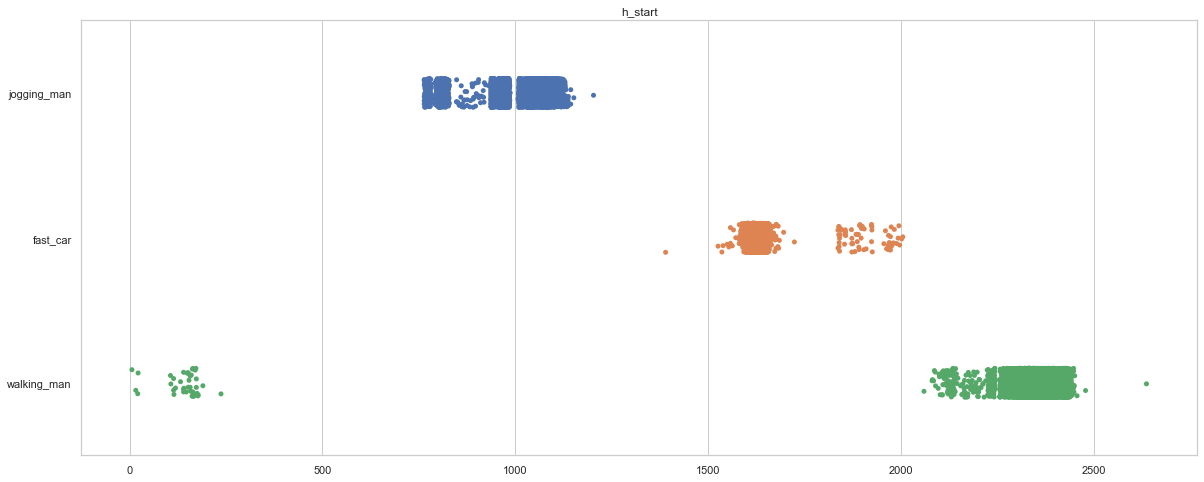

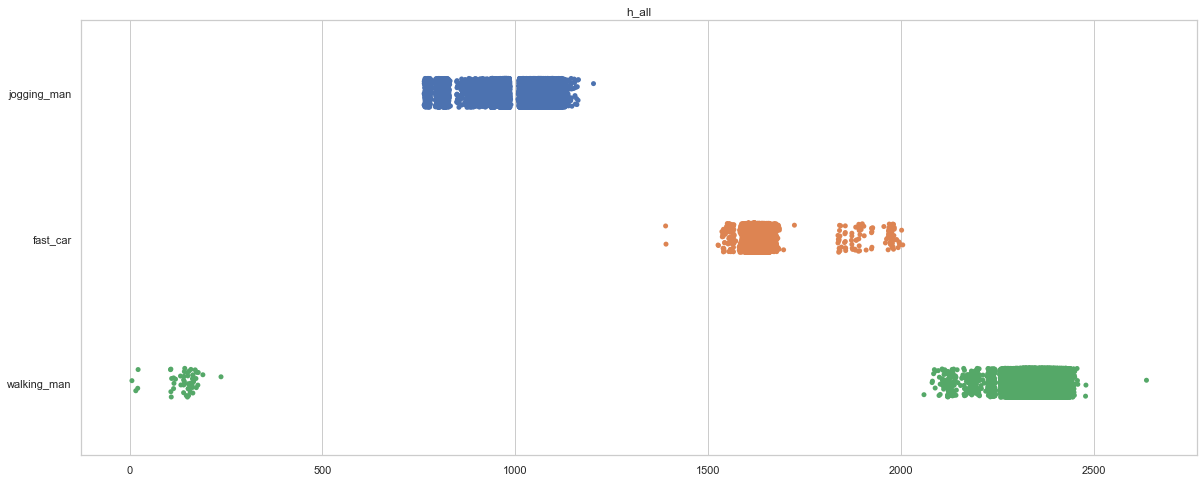

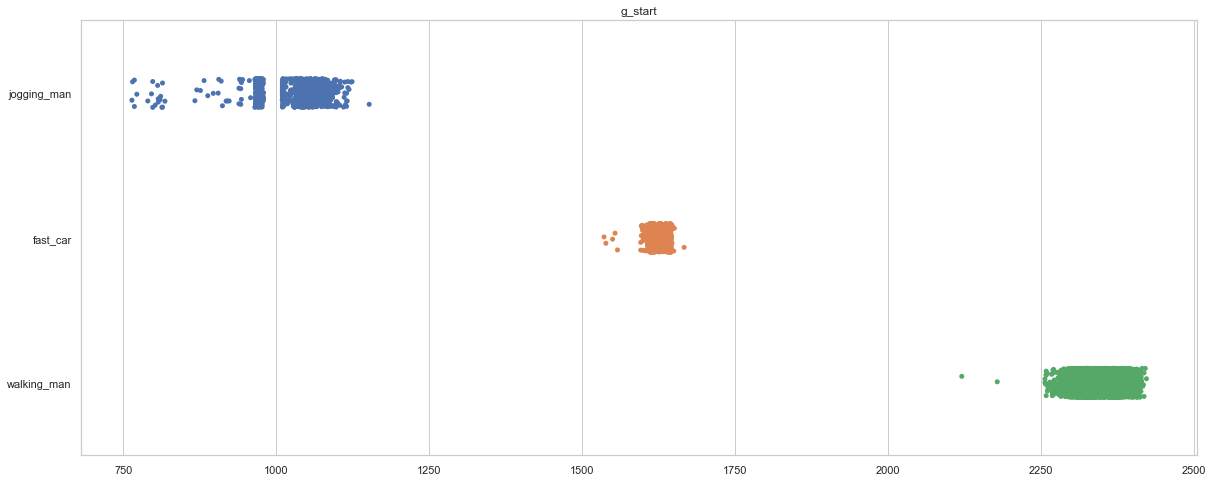

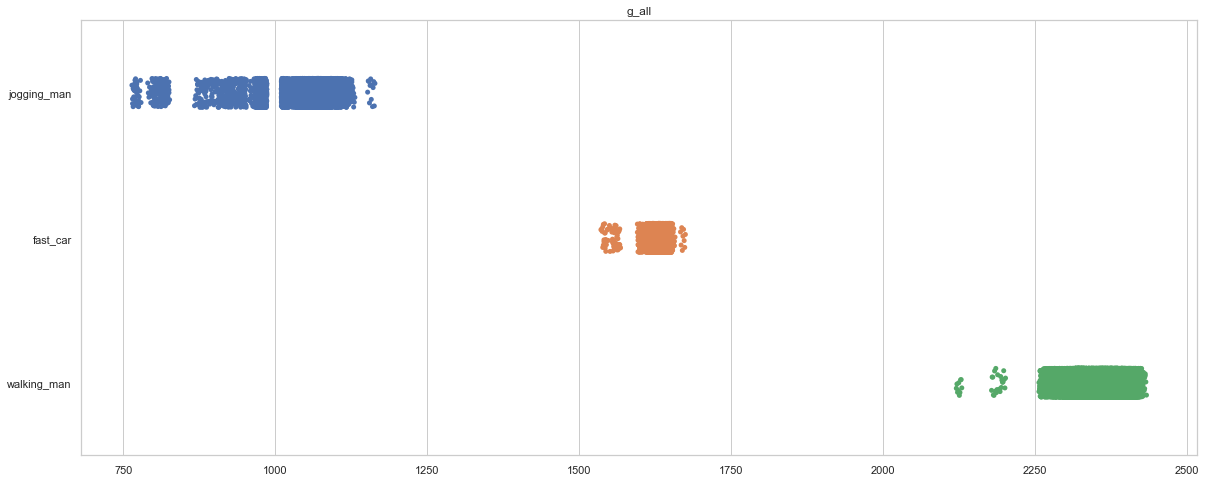

In [7]:
def plot_event_frames(frames_dict, title):
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    sns.stripplot(data=df, orient="h")
    plt.title(title)
    plt.show()


for k in res.keys():
    plot_event_frames(res[k], k)

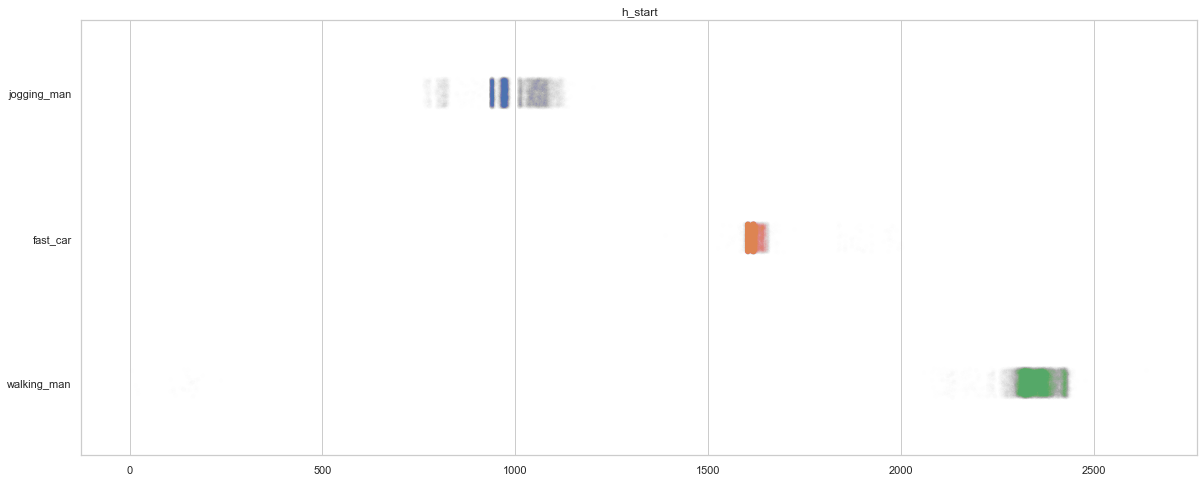

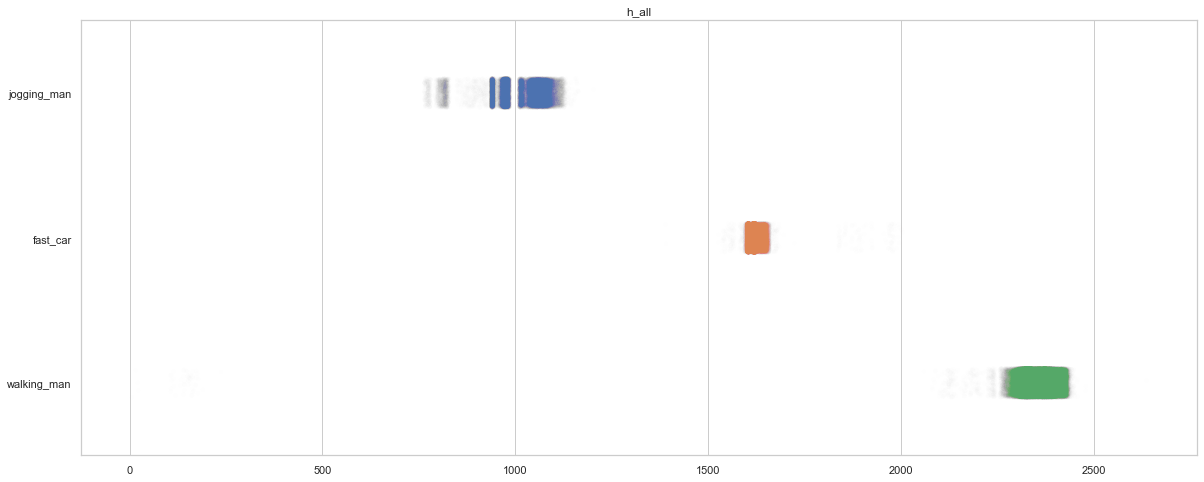

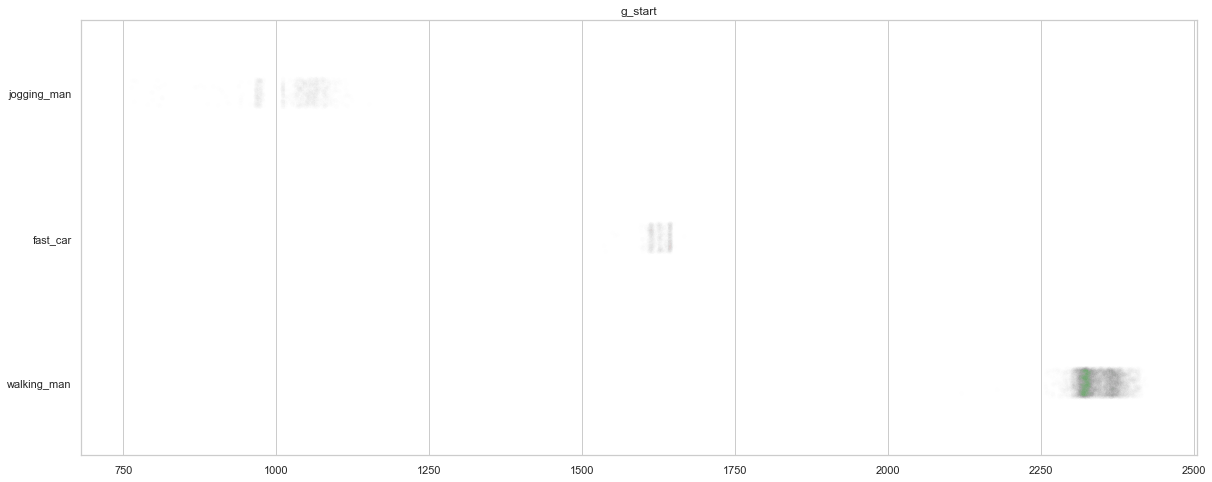

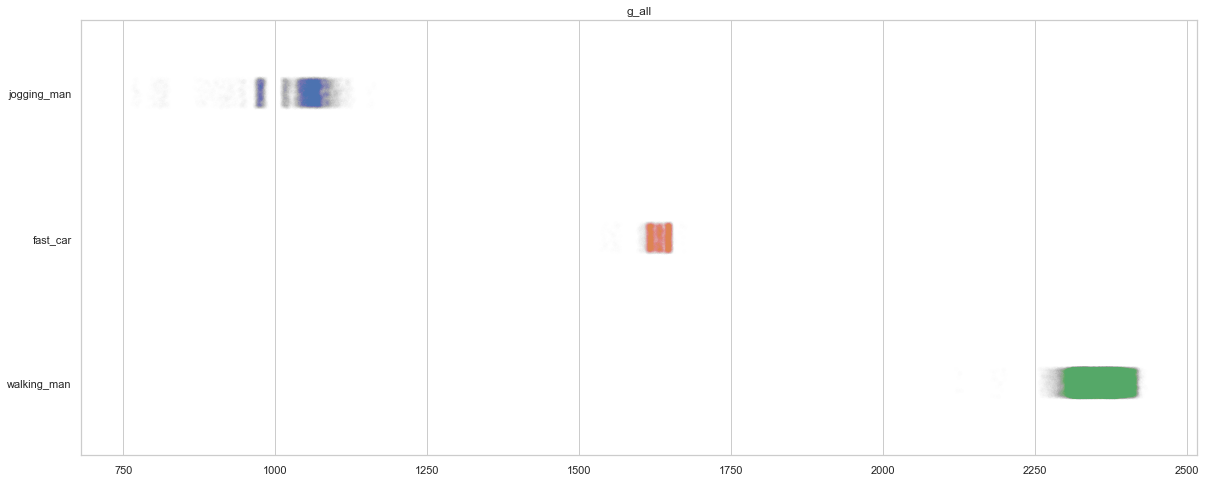

In [8]:
def plot_event_frames_alpha(frames_dict, title):
    df = pd.DataFrame.from_dict(
        data=frames_dict,
        orient="index",
    ).T
    sns.stripplot(data=df, orient="h", alpha=0.005)
    plt.title(title)
    plt.show()


for k in res.keys():
    plot_event_frames_alpha(res[k], k)

__Collect critical event frames ()

In [ ]:
def event_frames(uid):
    """
    Collect event frames and object names of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    cur = parts.loc[uid]
    cond = cur.condition
    side = cur.side
    quest = cur.questionnaire
    # store condition, side and if questionnaire
    hev_start[uid]["condition"] = cond
    hev_start[uid]["side"] = side
    hev_start[uid]["questionnaire"] = quest
    hev_all[uid]["condition"] = cond
    hev_all[uid]["side"] = side
    hev_all[uid]["questionnaire"] = quest
    gev_start[uid]["condition"] = cond
    gev_start[uid]["side"] = side
    gev_start[uid]["questionnaire"] = quest
    gev_all[uid]["condition"] = cond
    gev_all[uid]["side"] = side
    gev_all[uid]["questionnaire"] = quest
    for idx, e in enumerate(EVS):
        # select all hits of the current event
        query = h_events["name"].str.contains(e, regex=False, na=False)
        h_events = h_events[query]
        starts = h_events.start.tolist()
        ends = h_events.end.tolist()
        if len(starts) > 0:
            # store list of start hits (any)
            hev_start[uid][f"event_{idx+1}"] = starts
            # collect all hits
            frames = [
                [i for i in range(s, e + 1)] for s, e in zip(starts, ends)
            ]
            # flatten list
            frames = [h for hlist in frames for h in hlist]
            # store all hits
            hev_all[uid][f"event_{idx+1}"] = frames
            # select only gaze events
            h_events = h_events[h_events["type"] == "gaze"]
            starts = h_events.start.tolist()
            ends = h_events.end.tolist()
            # store list of start hits (gazes)
            gev_start[uid][f"event_{idx+1}"] = starts
            # collect all hits
            frames = [
                [i for i in range(s, e + 1)] for s, e in zip(starts, ends)
            ]
            # flatten list
            frames = [h for hlist in frames for h in hlist]
            # store all gaze hits
            gev_all[uid][f"event_{idx+1}"] = frames


EVS = ["jogging_man", "fast_car", "walking_man"]

# participants ids
uids = parts.index.tolist()

shev_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 Start HEVS Proxy Dicts",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)
ahev_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 All HEVS Proxy Dicts",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)
sgev_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 Start GEVS Proxy Dicts",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)
agev_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 All GEVS Proxy Dicts",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

manager = Manager()  # manage shared memory types


def new_struct():
    # simplify inner structure
    struct = {f"event_{i}": manager.list() for i in range(1, 4)}
    struct["condition"] = None
    struct["side"] = None
    struct["questionnaire"] = None
    struct = manager.dict(struct)
    return struct


# convert into memory-shared dict of dicts for multiprocessing
hev_start = manager.dict({uid: new_struct() for uid in shev_pbar})
hev_all = manager.dict({uid: new_struct() for uid in ahev_pbar})
gev_start = manager.dict({uid: new_struct() for uid in sgev_pbar})
gev_all = manager.dict({uid: new_struct() for uid in agev_pbar})


# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=event_frames, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

Decode collected frames (Dict and List Proxy types) and store them

In [39]:
def unpack_proxy_objects(p_obj):
    res = dict(p_obj)
    res = {k: dict(v) for k, v in res.items()}
    res = {
        k: {
            a: list(b) if isinstance(b, managers.ListProxy) else b
            for a, b in v.items()
        }
        for k, v in res.items()
    }
    return res


# make ListProxy and DictProxy types readable
h_start = unpack_proxy_objects(hev_start)
h_all = unpack_proxy_objects(hev_all)
g_start = unpack_proxy_objects(gev_start)
g_all = unpack_proxy_objects(gev_all)

# store them
with open("start_frames_hevents.json", "w") as outfile:
    json.dump(h_start, outfile)
with open("all_frames_hevents.json", "w") as outfile:
    json.dump(h_all, outfile)
with open("start_frames_gevents.json", "w") as outfile:
    json.dump(g_start, outfile)
with open("all_frames_gevents.json", "w") as outfile:
    json.dump(g_all, outfile)

008458d8209e4ba2bbfe7432f9417ec7 => event_1: [801, 942, 975, 1065]
b28f765180294426997226c0ef936954 => event_1: [973]
12288fb5ac564eca9367edae8bbe066f => event_1: [973]
1b9ddb310f6c40508da98f45915077a9 => event_1: [973]
83f496a6e1374e07b2e5d411c313856e => event_1: [897]
0f04f15432bb4504890662adf9e4f4d0 => event_1: [957]
fa1b985dd13347d4a37d6567a6a6798c => event_1: [939, 964]
f50bf9195655423bb0424565b9a55c93 => event_1: [1011]
567381bf521c4f61b2d50ace775f900f => event_1: [1063]
2f316c49d3474f0ab724a1e43fe21bdf => event_1: [1040]
c997a243a7564834bd68a2bb54b3055d => event_1: [1027]
ef8fd2c4d8114418bc2114044c69e3cf => event_1: [939, 969, 980, 985]
83f78e11b2d34ec1adaffd7c56b8e24a => event_1: [939, 1059, 1073]
2b729046ab7543e6ae9caf3597cc9a26 => event_1: [967]
4622de6229ba41e493ee51dcaaa56cb7 => event_1: [1066]
e8c5ff0419db478694253c881ac1a1d1 => event_1: [940]
729ad65643dd48e48854c52ad8582830 => event_1: [965, 1060, 1068, 1072]
96696617f4b84aa6860979112b450b86 => event_1: [982]
f076969e1c1

In [12]:
sns.set(rc={"figure.figsize": (23, 7)})
hs_df = pd.DataFrame(h_start).transpose()
hs_df

event_1 event_2 event_3   condition  \
4f583872ffed48249874b00f3d389cfc           []      []      []  TaxiDriver   
33d68ad55ef544fab9fd08108e3913ca           []      []      []        AVAS   
8598a83e2af441b8bcd0ae5d84beb875           []      []      []   RadioTalk   
37d7e67934974217830bb429bba7fd76           []      []      []        AVAS   
42bac596059749b5b8e8e83ae61de9b4           []      []      []  TaxiDriver   
...                                       ...     ...     ...         ...   
cfe9482181f74f80b88cd4b1c048ab94        [931]      []      []        AVAS   
611d35a7c3e940cc82495e53c2a8532d           []      []      []  TaxiDriver   
3b6fda285d9e412eb081986b2f22a2e3   [938, 960]      []      []        AVAS   
18ffb0abdc8642098c479380bfa533d1  [972, 1021]      []      []   RadioTalk   
c06f123b35b74bb489ec239b1cac9eb4   [941, 981]      []      []  TaxiDriver   

                                   side questionnaire  
4f583872ffed48249874b00f3d389cfc  right            No  
33d68ad55ef544fab9fd08108e3913ca  right            No  
8598a83e2af441b8bcd0ae5d84beb875  right            No  
37d7e67934974217830bb429bba7fd76   left            No  
42bac596059749b5b8e8e83ae61de9b4  right            No  
...                                 ...           ...  
cfe9482181f74f80b88cd4b1c048ab94  right            No  
611d35a7c3e940cc82495e53c2a8532d  right            No  
3b6fda285d9e412eb081986b2f22a2e3   left            No  
18ffb0abdc8642098c479380bfa533d1   left           Yes  
c06f123b35b74bb489ec239b1cac9eb4  right            No  

[24356 rows x 6 columns]

📄 0 of 24356 📂 participants processed:                                                                        …

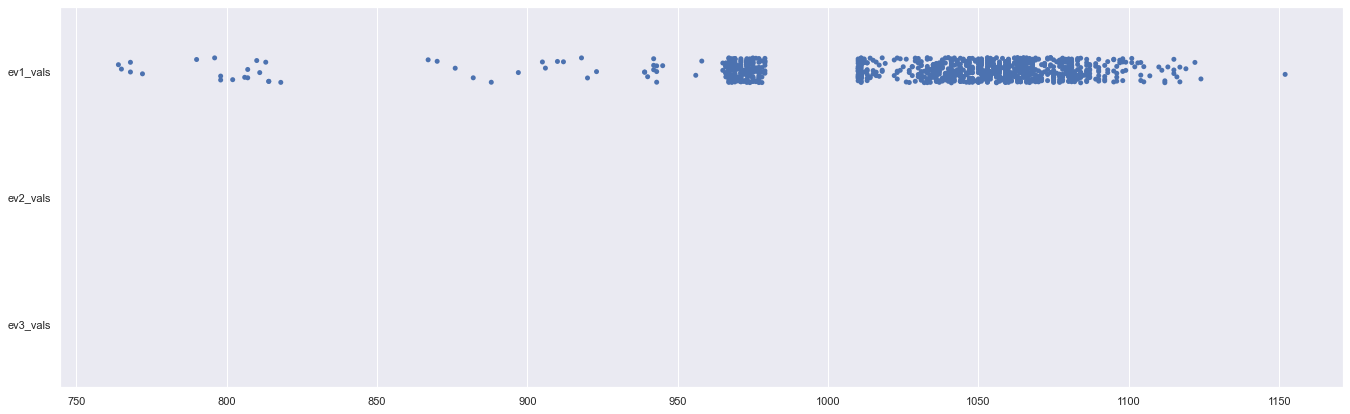

In [35]:
sns.set(rc={"figure.figsize": (23, 7)})
hs_df = pd.DataFrame(g_start).transpose()
hs_df
uids = list(g_start.keys())
# participants progress bar
keys_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)
ev1_vals = [v for l in hs_df["event_1"].values for v in l]
ev2_vals = [v for l in hs_df["event_2"].values for v in l]
ev3_vals = [v for l in hs_df["event_3"].values for v in l]

df = pd.DataFrame.from_dict(
    data=dict(ev1_vals=ev1_vals, ev2_vals=ev2_vals, ev3_vals=ev3_vals),
    orient="index",
).T

sns.stripplot(data=df, orient="h")
# for k in keys_pbar:
#     # sns.stripplot(x=h_start[k]["event_2"], alpha=0.005)
#     sns.stripplot(x=h_start[k], order=["event_1", "event_2", "event_3"])
#     # sns.stripplot(x=h_start[k]["event_2"], color="yellow", order="car")
#     # sns.stripplot(x=h_start[k]["event_3"], color="green", order="walking")
plt.show()

In [16]:
with open("frames_events.json") as f:
    test = json.load(f)

In [17]:
for k in list(test.keys())[:1]:
    print(type(test[k]))

<class 'list'>


In [18]:
"""
Event1: 1162-1400
Event2: 1958-2080
Event3: 2596-2890
"""

'\nEvent1: 1162-1400\nEvent2: 1958-2080\nEvent3: 2596-2890\n'

In [21]:
sns.set(rc={"figure.figsize": (23, 7)})

keys = list(test.keys())
# participants progress bar
keys_pbar = tqdm(
    iterable=keys,
    total=len(keys),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for k in keys_pbar:
    sns.stripplot(x=test[k], alpha=0.005)
plt.show()

NameError: name 'test' is not defined

In [22]:
def gazes_vs_saccades(uid):
    """
    Collect hit (saccade/gaze) events and related info of a participant given
    its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """
    h_events = pd.read_csv(f"{PATH_PROC}/gazes/{uid}.csv")
    h_events = h_events[h_events.group != "Sky"]
    total = h_events.index.size

    rest = h_events[h_events["type"] == "rest"]
    gazes = h_events[h_events["type"] == "gaze"]

    total_r = rest.index.size
    total_g = gazes.index.size
    rest_len = rest["length"].sum()
    gaze_len = gazes["length"].sum()
    total_len = rest_len + gaze_len

    hev_cnts[uid]["rest_cnt"] = total_r
    hev_cnts[uid]["gaze_cnt"] = total_g
    hev_cnts[uid]["rest_avg"] = rest["length"].mean()
    hev_cnts[uid]["gaze_avg"] = gazes["length"].mean()
    hev_cnts[uid]["rest_mdn"] = rest["length"].median()
    hev_cnts[uid]["gaze_mdn"] = gazes["length"].median()
    hev_cnts[uid]["rest_dist_avg"] = rest["distance"].mean()
    hev_cnts[uid]["gaze_dist_avg"] = gazes["distance"].mean()
    hev_cnts[uid]["rest_dist_mdn"] = rest["distance"].median()
    hev_cnts[uid]["gaze_dist_mdn"] = gazes["distance"].median()
    hev_cnts[uid]["rest_len"] = rest_len
    hev_cnts[uid]["gaze_len"] = gaze_len
    hev_cnts[uid]["rest_l_%"] = rest_len * 100 / total_len
    hev_cnts[uid]["gaze_l_%"] = gaze_len * 100 / total_len
    hev_cnts[uid]["rest_c_%"] = total_r * 100 / total
    hev_cnts[uid]["gaze_c_%"] = total_g * 100 / total

    grps = gazes.group.unique()
    for grp in grps:
        sel = gazes[gazes.group == grp]
        g_len = sel["length"].sum()
        g_cnt = sel.index.size
        grp_lpercs[uid][grp] = g_len * 100 / gaze_len
        grp_cpercs[uid][grp] = g_cnt * 100 / total_g
        grp_len[uid][grp] = g_len
        grp_cnt[uid][grp] = g_cnt
    for grp in grp_cats:
        if not grp_lpercs[uid][grp]:
            grp_lpercs[uid][grp] = 0
            grp_cpercs[uid][grp] = 0
            grp_len[uid][grp] = 0
            grp_cnt[uid][grp] = 0


# participants ids
uids = parts.index.tolist()

cats = [
    "rest_cnt",
    "gaze_cnt",
    "rest_avg",
    "gaze_avg",
    "rest_mdn",
    "gaze_mdn",
    "rest_dist_avg",
    "gaze_dist_avg",
    "rest_dist_mdn",
    "gaze_dist_mdn",
    "rest_len",
    "gaze_len",
    "rest_l_%",
    "gaze_l_%",
    "rest_c_%",
    "gaze_c_%",
]
stats = {cat: None for cat in cats}

grp_cats = [
    "Buildings",
    # "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]
grp_stats = {cat: None for cat in grp_cats}

manager = Manager()  # manage shared memory types

# convert into memory-shared dict of dicts for multiprocessing
hev_cnts = manager.dict({uid: manager.dict(stats) for uid in uids})
grp_lpercs = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_cpercs = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_len = manager.dict({uid: manager.dict(grp_stats) for uid in uids})
grp_cnt = manager.dict({uid: manager.dict(grp_stats) for uid in uids})

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack)

# participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap_unordered(func=gazes_vs_saccades, iterable=uids),
    total=len(uids),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

# parse and store collected data
hev_cnts = dict(hev_cnts)
hev_cnts = {k: dict(v) for k, v in hev_cnts.items()}
hev_cnts = pd.DataFrame(hev_cnts).transpose()
hev_cnts.to_csv("./hit_events_counters.csv")
display(hev_cnts)

grp_lpercs = dict(grp_lpercs)
grp_cpercs = dict(grp_cpercs)
grp_len = dict(grp_len)
grp_cnt = dict(grp_cnt)
grp_lpercs = {k: dict(v) for k, v in grp_lpercs.items()}
grp_cpercs = {k: dict(v) for k, v in grp_cpercs.items()}
grp_len = {k: dict(v) for k, v in grp_len.items()}
grp_cnt = {k: dict(v) for k, v in grp_cnt.items()}
grp_lpercs = pd.DataFrame(grp_lpercs).transpose()
grp_cpercs = pd.DataFrame(grp_cpercs).transpose()
grp_len = pd.DataFrame(grp_len).transpose()
grp_cnt = pd.DataFrame(grp_cnt).transpose()
grp_lpercs.to_csv("./group_length_percentages.csv")
grp_cpercs.to_csv("./group_counts_percentages.csv")
grp_len.to_csv("./group_lengths.csv")
grp_cnt.to_csv("./group_counts.csv")
display(grp_lpercs)
display(grp_cpercs)
display(grp_len)
display(grp_cnt)

📄 0 of 24356 📂 participants processed:                                                                        …

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <Finalize object, dead>Exception ignored in: <Finalize object, dead><Finalize object, dead><Finalize object, dead><Finalize object, dead><Finalize object, dead><Finalize object, dead><Finalize object, dead>
<Finalize object, dead>





Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/util.py", line 224, in __call__
Traceback (most recent call last):
Exception ignored in:   File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/util.py", line 224, in __call__
Exception ignored in:   File "/home/st

KeyboardInterrupt: 

  File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
      File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
buf = self._recv(4)    
KeyboardInterrupt
  File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
chunk = read(handle, remaining)

chunk = read(handle, remaining)
          File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
chunk = read(handle, remaining)
  File "/home/student/m/mvidaldepalo/.local/share/miniconda3/lib/python3.8/multiprocessing/connection.py", line 379, in _recv

chunk = read(handle, remaining)KeyboardInterrupt
chunk = read(handle, remaining)
KeyboardInterruptKeyboardInterrupt
    KeyboardInterrupt
: : KeyboardIn

In [21]:
display(hev_cnts.describe())

rest_cnt  gaze_cnt  rest_avg  gaze_avg  rest_mdn  gaze_mdn  \
count 24356.000 24356.000 24355.000 24356.000 24355.000 24356.000   
mean    359.144    67.524     0.073     0.958     0.049     0.535   
std     155.739    13.208     0.008     0.988     0.017     0.803   
min       0.000     1.000     0.033     0.461     0.033     0.330   
25%     245.000    61.000     0.068     0.703     0.033     0.446   
50%     357.000    69.000     0.072     0.818     0.033     0.495   
75%     467.000    76.000     0.077     1.007     0.066     0.561   
max     958.000   102.000     0.143    88.143     0.149    88.143   

       rest_dist_avg  gaze_dist_avg  rest_dist_mdn  gaze_dist_mdn  rest_len  \
count      24355.000      24356.000      24355.000      24356.000 24356.000   
mean          77.799         68.652         43.551         35.107    25.499   
std           44.886         54.065         35.449         36.454     9.704   
min            0.236          0.267          0.165          0.267     0.000   
25%           41.345         19.174          7.308          2.465    18.711   
50%           80.208         59.114         41.028         22.380    25.905   
75%          110.569        108.475         68.260         62.087    32.406   
max          230.400        267.032        207.666        204.840    59.895   

       gaze_len  rest_l_%  gaze_l_%  rest_c_%  gaze_c_%  
count 24356.000 24356.000 24356.000 24356.000 24356.000  
mean     58.630    30.212    69.788    81.851    18.149  
std      10.288    11.101    11.101     7.120     7.120  
min      23.331     0.000    31.587     0.000     5.088  
25%      51.381    22.601    61.875    78.717    13.279  
50%      57.849    30.700    69.300    83.444    16.556  
75%      65.472    38.125    77.399    86.721    21.283  
max      88.143    68.413   100.000    94.912   100.000

In [8]:
hit_levs = pd.read_csv(f"./group_length_percentages.csv", index_col=0)
hit_levs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     31.366         1.574   
33d68ad55ef544fab9fd08108e3913ca      0.000         0.915   
8598a83e2af441b8bcd0ae5d84beb875     77.503         0.000   
37d7e67934974217830bb429bba7fd76     32.626         4.741   
42bac596059749b5b8e8e83ae61de9b4     63.825         0.000   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94     64.702         0.000   
611d35a7c3e940cc82495e53c2a8532d     30.988         0.000   
3b6fda285d9e412eb081986b2f22a2e3     13.843         0.000   
18ffb0abdc8642098c479380bfa533d1     32.460         0.582   
c06f123b35b74bb489ec239b1cac9eb4      0.719         4.261   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.911       3.204   6.127   
33d68ad55ef544fab9fd08108e3913ca                0.000      44.179   0.458   
8598a83e2af441b8bcd0ae5d84beb875                0.000       1.268   1.869   
37d7e67934974217830bb429bba7fd76                2.121       8.921   9.545   
42bac596059749b5b8e8e83ae61de9b4                0.000       0.974  11.815   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                0.000      12.226   5.204   
611d35a7c3e940cc82495e53c2a8532d                0.000      39.527   7.626   
3b6fda285d9e412eb081986b2f22a2e3                0.818      32.535   1.168   
18ffb0abdc8642098c479380bfa533d1                0.000      12.082  10.917   
c06f123b35b74bb489ec239b1cac9eb4                0.000      58.882   2.490   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 31.141        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 46.772        0.000               0.000   
8598a83e2af441b8bcd0ae5d84beb875  0.000        0.000               0.000   
37d7e67934974217830bb429bba7fd76  2.121        0.624               0.000   
42bac596059749b5b8e8e83ae61de9b4  0.000        0.000               0.000   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  4.619        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 29.381        0.000               1.986   
18ffb0abdc8642098c479380bfa533d1 14.119        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 21.251        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           1.967          22.709   
33d68ad55ef544fab9fd08108e3913ca           0.559           7.117   
8598a83e2af441b8bcd0ae5d84beb875           0.734          18.625   
37d7e67934974217830bb429bba7fd76           3.805          35.496   
42bac596059749b5b8e8e83ae61de9b4           4.263          19.123   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94           1.944          15.925   
611d35a7c3e940cc82495e53c2a8532d           1.719          14.930   
3b6fda285d9e412eb081986b2f22a2e3          10.397           9.871   
18ffb0abdc8642098c479380bfa533d1           3.275          25.182   
c06f123b35b74bb489ec239b1cac9eb4           3.210           6.198   

                                  Traffic Signs  
4f583872ffed48249874b00f3d389cfc          0.000  
33d68ad55ef544fab9fd08108e3913ca          0.000  
8598a83e2af441b8bcd0ae5d84beb875          0.000  
37d7e67934974217830bb429bba7fd76          0.000  
42bac596059749b5b8e8e83ae61de9b4          0.000  
...                                         ...  
cfe9482181f74f80b88cd4b1c048ab94          0.000  
611d35a7c3e940cc82495e53c2a8532d          0.591  
3b6fda285d9e412eb081986b2f22a2e3          0.000  
18ffb0abdc8642098c479380bfa533d1          1.383  
c06f123b35b74bb489ec239b1cac9eb4          2.988  

[24356 rows x 11 columns]

In [9]:
hit_cevs = pd.read_csv(f"./group_counts_percentages.csv", index_col=0)
hit_cevs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     34.328         2.985   
33d68ad55ef544fab9fd08108e3913ca      0.000         2.500   
8598a83e2af441b8bcd0ae5d84beb875     64.865         0.000   
37d7e67934974217830bb429bba7fd76     37.681         4.348   
42bac596059749b5b8e8e83ae61de9b4     57.143         0.000   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94     62.687         0.000   
611d35a7c3e940cc82495e53c2a8532d     33.929         0.000   
3b6fda285d9e412eb081986b2f22a2e3     11.765         0.000   
18ffb0abdc8642098c479380bfa533d1     31.169         1.299   
c06f123b35b74bb489ec239b1cac9eb4      1.190         3.571   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.493       4.478  11.940   
33d68ad55ef544fab9fd08108e3913ca                0.000      52.500   1.250   
8598a83e2af441b8bcd0ae5d84beb875                0.000       5.405   8.108   
37d7e67934974217830bb429bba7fd76                1.449      14.493  15.942   
42bac596059749b5b8e8e83ae61de9b4                0.000       2.857  20.000   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                0.000      13.433   8.955   
611d35a7c3e940cc82495e53c2a8532d                0.000      32.143  14.286   
3b6fda285d9e412eb081986b2f22a2e3                1.176      30.588   2.353   
18ffb0abdc8642098c479380bfa533d1                0.000      16.883  15.584   
c06f123b35b74bb489ec239b1cac9eb4                0.000      57.143   4.762   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 28.358        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 40.000        0.000               0.000   
8598a83e2af441b8bcd0ae5d84beb875  0.000        0.000               0.000   
37d7e67934974217830bb429bba7fd76  5.797        1.449               0.000   
42bac596059749b5b8e8e83ae61de9b4  0.000        0.000               0.000   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  7.143        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 34.118        0.000               2.353   
18ffb0abdc8642098c479380bfa533d1 12.987        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 23.810        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           5.970          10.448   
33d68ad55ef544fab9fd08108e3913ca           1.250           2.500   
8598a83e2af441b8bcd0ae5d84beb875           2.703          18.919   
37d7e67934974217830bb429bba7fd76           8.696          10.145   
42bac596059749b5b8e8e83ae61de9b4           7.143          12.857   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94           2.985          11.940   
611d35a7c3e940cc82495e53c2a8532d           5.357           5.357   
3b6fda285d9e412eb081986b2f22a2e3          10.588           7.059   
18ffb0abdc8642098c479380bfa533d1           5.195          14.286   
c06f123b35b74bb489ec239b1cac9eb4           2.381           2.381   

                                  Traffic Signs  
4f583872ffed48249874b00f3d389cfc          0.000  
33d68ad55ef544fab9fd08108e3913ca          0.000  
8598a83e2af441b8bcd0ae5d84beb875          0.000  
37d7e67934974217830bb429bba7fd76          0.000  
42bac596059749b5b8e8e83ae61de9b4          0.000  
...                                         ...  
cfe9482181f74f80b88cd4b1c048ab94          0.000  
611d35a7c3e940cc82495e53c2a8532d          1.786  
3b6fda285d9e412eb081986b2f22a2e3          0.000  
18ffb0abdc8642098c479380bfa533d1          2.597  
c06f123b35b74bb489ec239b1cac9eb4          4.762  

[24356 rows x 11 columns]

In [10]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     31.366         1.574   
33d68ad55ef544fab9fd08108e3913ca      0.000         0.915   
8598a83e2af441b8bcd0ae5d84beb875     77.503         0.000   
37d7e67934974217830bb429bba7fd76     32.626         4.741   
42bac596059749b5b8e8e83ae61de9b4     63.825         0.000   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94     64.702         0.000   
611d35a7c3e940cc82495e53c2a8532d     30.988         0.000   
3b6fda285d9e412eb081986b2f22a2e3     13.843         0.000   
18ffb0abdc8642098c479380bfa533d1     32.460         0.582   
c06f123b35b74bb489ec239b1cac9eb4      0.719         4.261   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.911       3.204   6.127   
33d68ad55ef544fab9fd08108e3913ca                0.000      44.179   0.458   
8598a83e2af441b8bcd0ae5d84beb875                0.000       1.268   1.869   
37d7e67934974217830bb429bba7fd76                2.121       8.921   9.545   
42bac596059749b5b8e8e83ae61de9b4                0.000       0.974  11.815   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                0.000      12.226   5.204   
611d35a7c3e940cc82495e53c2a8532d                0.000      39.527   7.626   
3b6fda285d9e412eb081986b2f22a2e3                0.818      32.535   1.168   
18ffb0abdc8642098c479380bfa533d1                0.000      12.082  10.917   
c06f123b35b74bb489ec239b1cac9eb4                0.000      58.882   2.490   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 31.141        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 46.772        0.000               0.000   
8598a83e2af441b8bcd0ae5d84beb875  0.000        0.000               0.000   
37d7e67934974217830bb429bba7fd76  2.121        0.624               0.000   
42bac596059749b5b8e8e83ae61de9b4  0.000        0.000               0.000   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  4.619        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 29.381        0.000               1.986   
18ffb0abdc8642098c479380bfa533d1 14.119        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 21.251        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           1.967          22.709   
33d68ad55ef544fab9fd08108e3913ca           0.559           7.117   
8598a83e2af441b8bcd0ae5d84beb875           0.734          18.625   
37d7e67934974217830bb429bba7fd76           3.805          35.496   
42bac596059749b5b8e8e83ae61de9b4           4.263          19.123   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94           1.944          15.925   
611d35a7c3e940cc82495e53c2a8532d           1.719          14.930   
3b6fda285d9e412eb081986b2f22a2e3          10.397           9.871   
18ffb0abdc8642098c479380bfa533d1           3.275          25.182   
c06f123b35b74bb489ec239b1cac9eb4           3.210           6.198   

                                  Traffic Signs  expo   side   condition  \
4f583872ffed48249874b00f3d389cfc          0.000   MSW  right  TaxiDriver   
33d68ad55ef544fab9fd08108e3913ca          0.000   MSW  right        AVAS   
8598a83e2af441b8bcd0ae5d84beb875          0.000   MSW  right   RadioTalk   
37d7e67934974217830bb429bba7fd76          0.000   MSW   left        AVAS   
42bac596059749b5b8e8e83ae61de9b4          0.000   MSW  right  TaxiDriver   
...                                         ...   ...    ...         ...   
cfe9482181f74f80b88cd4b1c048ab94          0.000  BMBF  right        AVAS   
611d35a7c3e940cc82495e53c2a8532d      

In [11]:
hit_cevs = hit_cevs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_cevs

Buildings  Dynamic Cars  \
4f583872ffed48249874b00f3d389cfc     34.328         2.985   
33d68ad55ef544fab9fd08108e3913ca      0.000         2.500   
8598a83e2af441b8bcd0ae5d84beb875     64.865         0.000   
37d7e67934974217830bb429bba7fd76     37.681         4.348   
42bac596059749b5b8e8e83ae61de9b4     57.143         0.000   
...                                     ...           ...   
cfe9482181f74f80b88cd4b1c048ab94     62.687         0.000   
611d35a7c3e940cc82495e53c2a8532d     33.929         0.000   
3b6fda285d9e412eb081986b2f22a2e3     11.765         0.000   
18ffb0abdc8642098c479380bfa533d1     31.169         1.299   
c06f123b35b74bb489ec239b1cac9eb4      1.190         3.571   

                                  Dynamic Pedestrians  Inside Car  Nature  \
4f583872ffed48249874b00f3d389cfc                1.493       4.478  11.940   
33d68ad55ef544fab9fd08108e3913ca                0.000      52.500   1.250   
8598a83e2af441b8bcd0ae5d84beb875                0.000       5.405   8.108   
37d7e67934974217830bb429bba7fd76                1.449      14.493  15.942   
42bac596059749b5b8e8e83ae61de9b4                0.000       2.857  20.000   
...                                               ...         ...     ...   
cfe9482181f74f80b88cd4b1c048ab94                0.000      13.433   8.955   
611d35a7c3e940cc82495e53c2a8532d                0.000      32.143  14.286   
3b6fda285d9e412eb081986b2f22a2e3                1.176      30.588   2.353   
18ffb0abdc8642098c479380bfa533d1                0.000      16.883  15.584   
c06f123b35b74bb489ec239b1cac9eb4                0.000      57.143   4.762   

                                  Roads  Static Cars  Static Pedestrians  \
4f583872ffed48249874b00f3d389cfc 28.358        0.000               0.000   
33d68ad55ef544fab9fd08108e3913ca 40.000        0.000               0.000   
8598a83e2af441b8bcd0ae5d84beb875  0.000        0.000               0.000   
37d7e67934974217830bb429bba7fd76  5.797        1.449               0.000   
42bac596059749b5b8e8e83ae61de9b4  0.000        0.000               0.000   
...                                 ...          ...                 ...   
cfe9482181f74f80b88cd4b1c048ab94  0.000        0.000               0.000   
611d35a7c3e940cc82495e53c2a8532d  7.143        0.000               0.000   
3b6fda285d9e412eb081986b2f22a2e3 34.118        0.000               2.353   
18ffb0abdc8642098c479380bfa533d1 12.987        0.000               0.000   
c06f123b35b74bb489ec239b1cac9eb4 23.810        0.000               0.000   

                                  Street Objects  Traffic Lights  \
4f583872ffed48249874b00f3d389cfc           5.970          10.448   
33d68ad55ef544fab9fd08108e3913ca           1.250           2.500   
8598a83e2af441b8bcd0ae5d84beb875           2.703          18.919   
37d7e67934974217830bb429bba7fd76           8.696          10.145   
42bac596059749b5b8e8e83ae61de9b4           7.143          12.857   
...                                          ...             ...   
cfe9482181f74f80b88cd4b1c048ab94           2.985          11.940   
611d35a7c3e940cc82495e53c2a8532d           5.357           5.357   
3b6fda285d9e412eb081986b2f22a2e3          10.588           7.059   
18ffb0abdc8642098c479380bfa533d1           5.195          14.286   
c06f123b35b74bb489ec239b1cac9eb4           2.381           2.381   

                                  Traffic Signs  expo   side   condition  \
4f583872ffed48249874b00f3d389cfc          0.000   MSW  right  TaxiDriver   
33d68ad55ef544fab9fd08108e3913ca          0.000   MSW  right        AVAS   
8598a83e2af441b8bcd0ae5d84beb875          0.000   MSW  right   RadioTalk   
37d7e67934974217830bb429bba7fd76          0.000   MSW   left        AVAS   
42bac596059749b5b8e8e83ae61de9b4          0.000   MSW  right  TaxiDriver   
...                                         ...   ...    ...         ...   
cfe9482181f74f80b88cd4b1c048ab94          0.000  BMBF  right        AVAS   
611d35a7c3e940cc82495e53c2a8532d      

In [12]:
display(hit_levs.describe())
display(hit_cevs.describe())

Buildings  Dynamic Cars  Dynamic Pedestrians  Inside Car    Nature  \
count  24356.000     24356.000            24356.000   24356.000 24356.000   
mean      27.564         0.785                0.488      33.460     4.701   
std       23.119         1.466                0.946      26.096     4.732   
min        0.000         0.000                0.000       0.000     0.000   
25%        4.582         0.000                0.000      10.501     0.598   
50%       24.284         0.000                0.000      27.525     3.375   
75%       47.656         0.991                0.666      54.332     7.546   
max       84.044        14.747               17.388     100.000    32.171   

          Roads  Static Cars  Static Pedestrians  Street Objects  \
count 24356.000    24356.000           24356.000       24356.000   
mean     17.761        0.052               0.056           2.084   
std      18.454        0.256               0.309           2.306   
min       0.000        0.000               0.000           0.000   
25%       3.208        0.000               0.000           0.000   
50%      12.281        0.000               0.000           1.407   
75%      26.242        0.000               0.000           3.197   
max     100.000        5.383               8.671          27.878   

       Traffic Lights  Traffic Signs  
count       24356.000      24356.000  
mean           12.755          0.294  
std             6.499          0.926  
min             0.000          0.000  
25%             7.151          0.000  
50%            12.174          0.000  
75%            17.329          0.000  
max            40.564         13.337

Buildings  Dynamic Cars  Dynamic Pedestrians  Inside Car    Nature  \
count  24356.000     24356.000            24356.000   24356.000 24356.000   
mean      27.546         1.114                0.935      33.862     7.484   
std       20.876         1.766                1.547      23.273     6.677   
min        0.000         0.000                0.000       0.000     0.000   
25%        7.353         0.000                0.000      13.924     1.429   
50%       26.087         0.000                0.000      30.303     6.250   
75%       45.783         1.538                1.471      52.857    12.069   
max       84.375        15.625               19.753     100.000    39.080   

          Roads  Static Cars  Static Pedestrians  Street Objects  \
count 24356.000    24356.000           24356.000       24356.000   
mean     17.303        0.096               0.092           3.654   
std      15.334        0.423               0.413           3.739   
min       0.000        0.000               0.000           0.000   
25%       4.348        0.000               0.000           0.000   
50%      14.103        0.000               0.000           2.778   
75%      26.667        0.000               0.000           5.479   
max     100.000        6.349               5.882          39.474   

       Traffic Lights  Traffic Signs  
count       24356.000      24356.000  
mean            7.381          0.533  
std             4.077          1.528  
min             0.000          0.000  
25%             4.000          0.000  
50%             7.143          0.000  
75%            10.169          0.000  
max            35.714         18.033

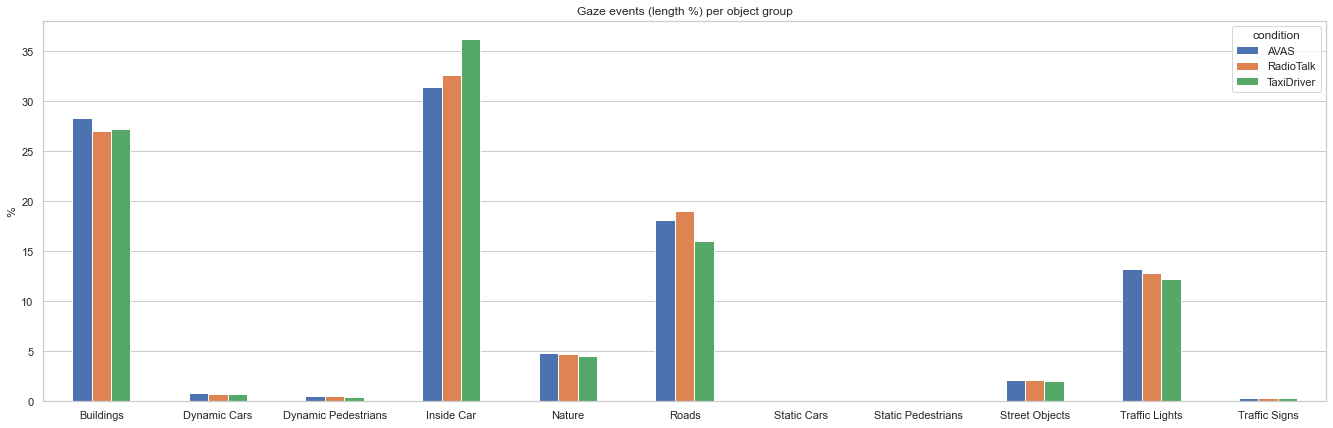

In [13]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_levs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (length %) per object group")

plt.show()

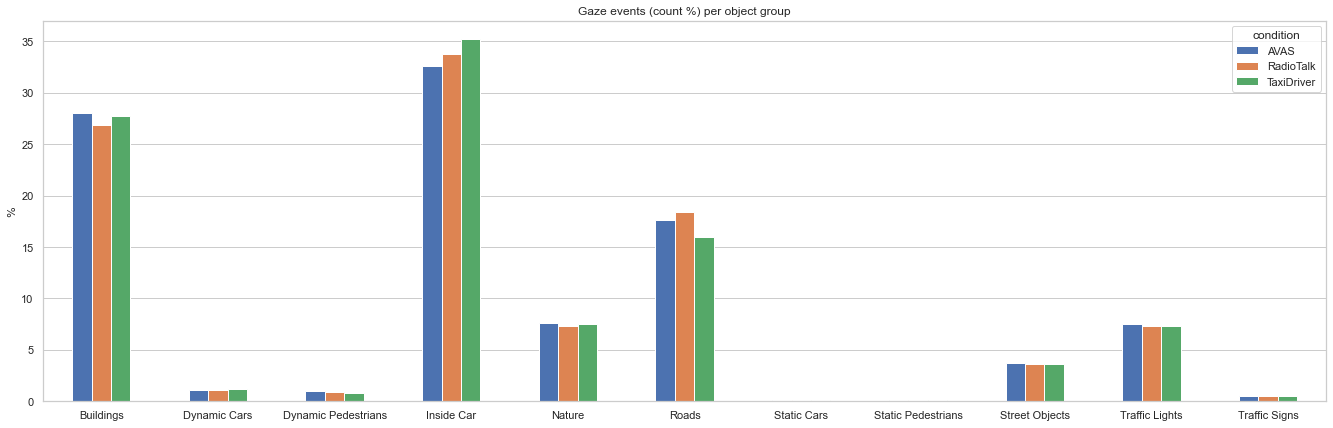

In [15]:
sns.set(rc={"figure.figsize": (23, 7)})
sns.set_style(STYLE)  # set seaborn plotting style

ax = hit_cevs.groupby(["condition"]).mean().transpose().plot.bar(rot=0)

ax.set_ylabel("%")
ax.xaxis.grid(False)

plt.title("Gaze events (count %) per object group")

plt.show()

In [16]:
grp_cats = [
    "Buildings",
    # "Crosswalks",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    # "End",
    # "Events",
    "Inside Car",
    "Nature",
    "Roads",
    # "Sky",
    # "Start",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette

colors = [next(palette) for i in range(3)]

sns.set_style(STYLE)  # set seaborn plotting style


def normalize_from_condition(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    s = s / s.loc["TaxiDriver"] - 1
    return s.loc[["AVAS", "RadioTalk"]]


def normalize_series(s):
    """Normalize a series (dataframe column)."""
    # Mean normalization: (s - s.min()) / (s.max() - s.min())
    # Std normalization: (s - s.mean()) / s.std()
    return (s - s.min()) / (s.max() - s.min())

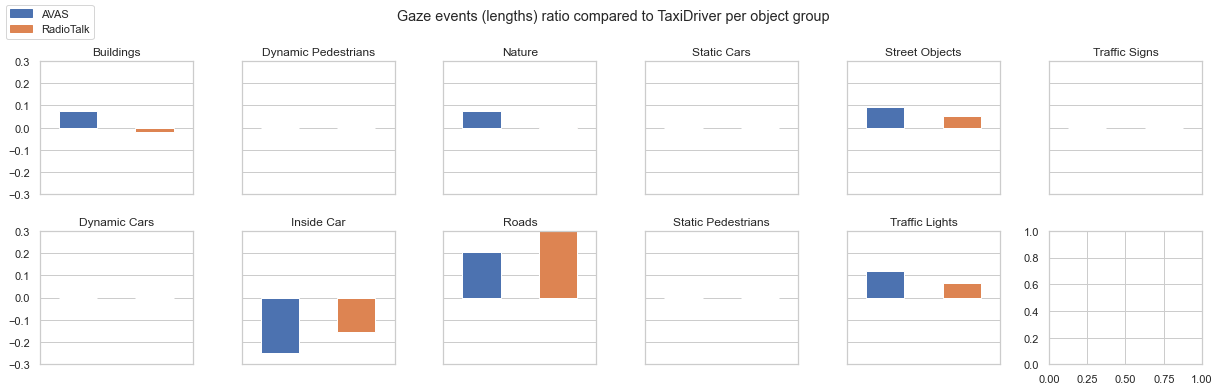

In [17]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

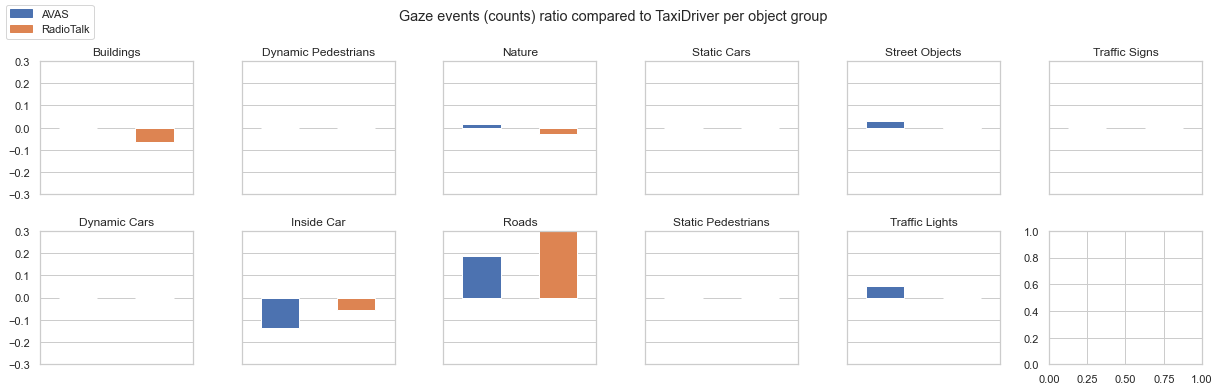

In [31]:
NROWS = 2
NCOLS = 6

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            s = normalize_from_condition(
                hit_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.3, 0.3)
            ax.set_xticks([])

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

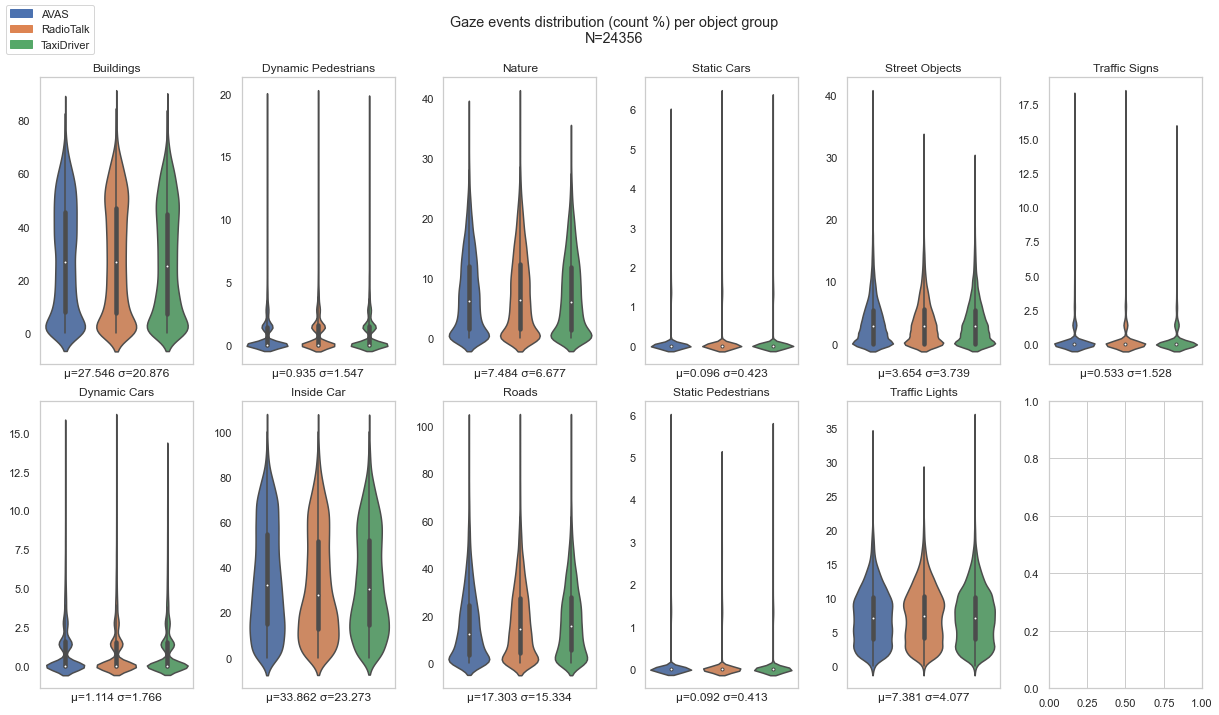

In [18]:
NROWS = 2
NCOLS = 6
N = hit_cevs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (count %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_cevs[grp].mean()
            std = hit_cevs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=hit_cevs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

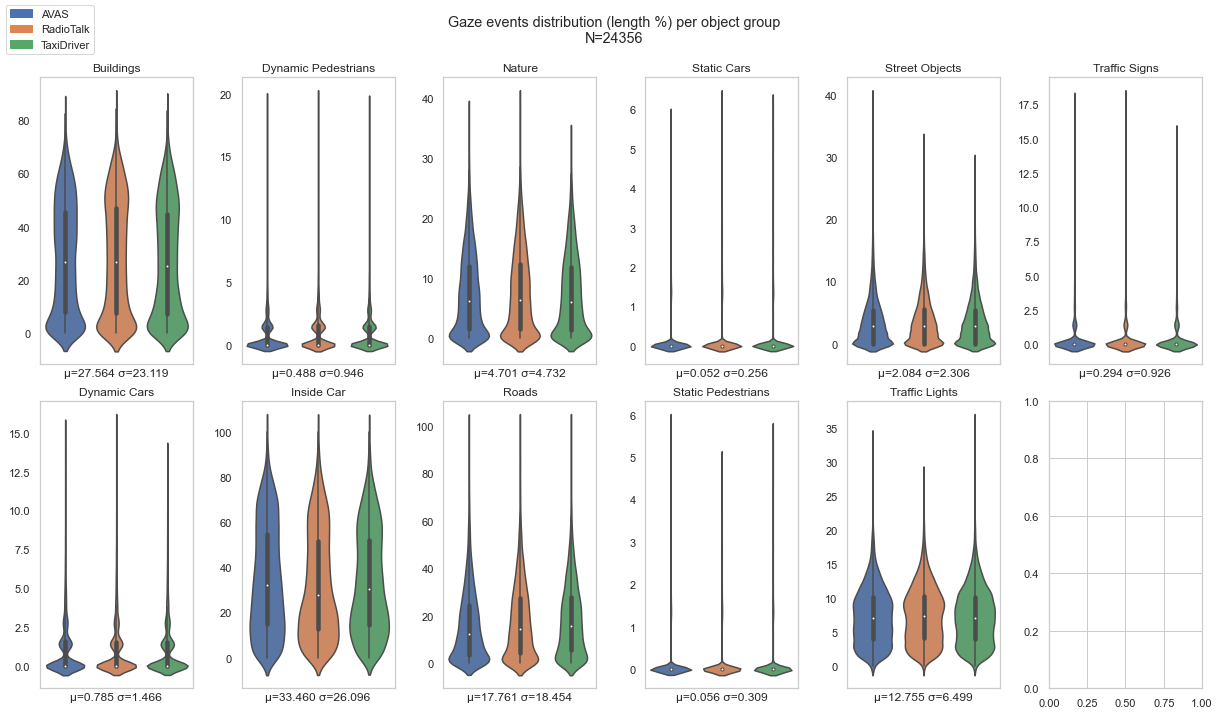

In [20]:
NROWS = 2
NCOLS = 6
N = hit_levs.index.size

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(17, 10))
fig.suptitle(f"Gaze events distribution (length %) per object group\nN={N}\n")
fig.tight_layout()

# h_cs = hit_cevs.groupby(["condition"])

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 11:
            grp = grp_cats[i]
            mean = hit_levs[grp].mean()
            std = hit_levs[grp].std()
            title_extra = f"μ={mean:.3f} σ={std:.3f}"
            # s = normalize_series(hit_cevs[grp])
            ax = sns.violinplot(
                data=hit_cevs, x="condition", y=grp, ax=axes[r, c]
            )
            i += 1
            # if c != 0:
            #     ax.set_yticklabels([])
            ax.set_ylabel(None)
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(f"{grp}")
            ax.set_xlabel(title_extra)
            # ax.set_ylim(-10, 110)
            ax.set_xticks([])
            ax.grid(False)

avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
taxi_patch = mpatches.Patch(color=colors[2], label="TaxiDriver")
fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

Final Groups

In [21]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = (
    hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
)
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = (
    hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
)
gaze_levs["Traffic Signs"] = (
    hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]
)

# count
gaze_cevs = hit_cevs[final_groups]
gaze_cevs["Cars and Pedestrians"] = (
    hit_cevs["Dynamic Cars"] + hit_cevs["Dynamic Pedestrians"]
)
gaze_cevs["Roads"] = hit_cevs["Static Cars"] + hit_cevs["Roads"]
gaze_cevs["Street Objects"] = (
    hit_cevs["Street Objects"] + hit_cevs["Static Pedestrians"]
)
gaze_cevs["Traffic Signs"] = (
    hit_cevs["Traffic Signs"] + hit_cevs["Traffic Lights"]
)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_levs["Cars and Pedestrians"]
    + gaze_levs["Roads"]
    + gaze_levs["Traffic Signs"]
)
gaze_ltr["non-TR"] = (
    gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
)
gaze_ltr["condition"] = gaze_levs["condition"]
gaze_ctr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ctr["TR"] = (
    gaze_cevs["Cars and Pedestrians"]
    + gaze_cevs["Roads"]
    + gaze_cevs["Traffic Signs"]
)
gaze_ctr["non-TR"] = (
    gaze_cevs["Buildings"] + gaze_cevs["Nature"] + gaze_cevs["Street Objects"]
)
gaze_ctr["condition"] = gaze_cevs["condition"]

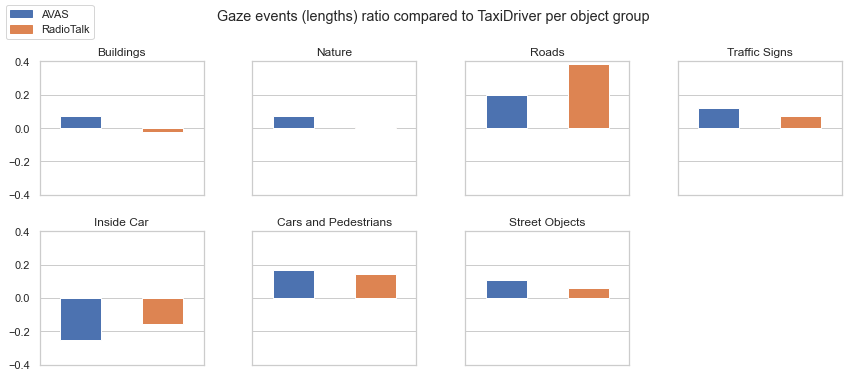

In [22]:
NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

groups = gaze_levs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_levs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.4, 0.4)
            ax.set_xticks([])

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

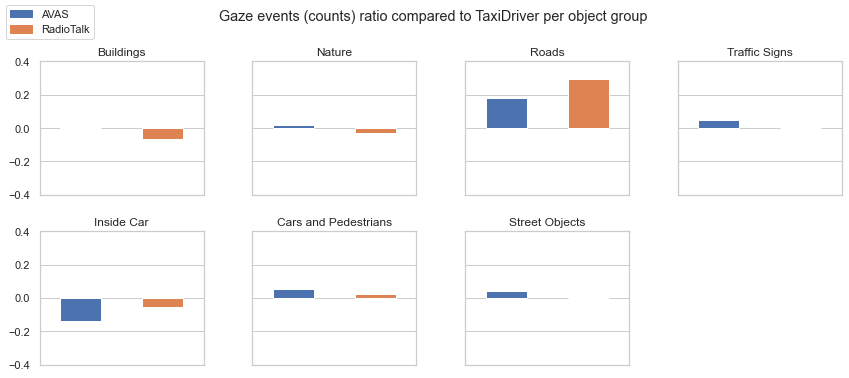

In [23]:
NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(12, 5.5))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver per object group\n"
)
fig.tight_layout()

groups = gaze_cevs.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if i < 7:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_cevs.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.4, 0.4)
            ax.set_xticks([])

fig.delaxes(axes[1, 3])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="upper left")
plt.show()

TR vs non-TR

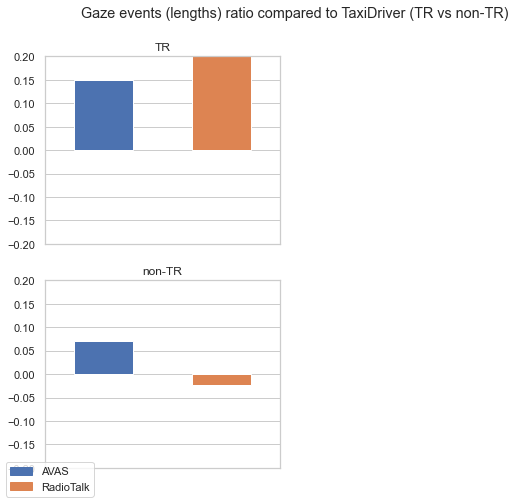

In [24]:
NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (lengths) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ltr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ltr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.2, 0.2)
            ax.set_xticks([])

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()

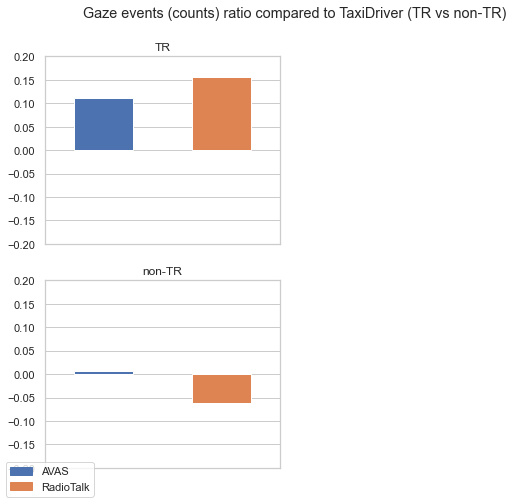

In [38]:
NROWS = 2
NCOLS = 2

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 7))
fig.suptitle(
    "Gaze events (counts) ratio compared to TaxiDriver (TR vs non-TR)\n"
)
fig.tight_layout()

groups = gaze_ctr.drop("condition", axis=1).columns

i = 0
for c in range(NCOLS):
    for r in range(NROWS):
        if c < 1:
            grp = groups[i]
            s = normalize_from_condition(
                gaze_ctr.groupby(["condition"])[grp].median()
            )
            ax = s.transpose().plot.bar(rot=0, color=colors, ax=axes[r, c])
            i += 1
            if c != 0:
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            ax.set_title(grp)
            ax.set_ylim(-0.2, 0.2)
            ax.set_xticks([])

fig.delaxes(axes[1, 1])
fig.delaxes(axes[0, 1])
avas_patch = mpatches.Patch(color=colors[0], label="AVAS")
radio_patch = mpatches.Patch(color=colors[1], label="RadioTalk")
fig.legend(handles=[avas_patch, radio_patch], loc="lower left")
plt.show()

In [25]:
parts

date  expo   side  \
id                                                                   
4f583872ffed48249874b00f3d389cfc  2019-05-14 13:21:00   MSW  right   
33d68ad55ef544fab9fd08108e3913ca  2019-05-14 16:44:00   MSW  right   
8598a83e2af441b8bcd0ae5d84beb875  2019-05-14 16:51:00   MSW  right   
37d7e67934974217830bb429bba7fd76  2019-05-14 16:54:00   MSW   left   
42bac596059749b5b8e8e83ae61de9b4  2019-05-14 16:56:00   MSW  right   
...                                               ...   ...    ...   
cfe9482181f74f80b88cd4b1c048ab94  2019-12-30 15:29:00  BMBF  right   
611d35a7c3e940cc82495e53c2a8532d  2020-01-03 16:12:00  BMBF  right   
3b6fda285d9e412eb081986b2f22a2e3  2020-01-03 16:13:00  BMBF   left   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:15:00  BMBF   left   
c06f123b35b74bb489ec239b1cac9eb4  2020-01-03 16:16:00  BMBF  right   

                                   condition questionnaire  nulls_%  
id                                                                   
4f583872ffed48249874b00f3d389cfc  TaxiDriver            No    1.610  
33d68ad55ef544fab9fd08108e3913ca        AVAS            No    0.037  
8598a83e2af441b8bcd0ae5d84beb875   RadioTalk            No    0.037  
37d7e67934974217830bb429bba7fd76        AVAS            No    0.824  
42bac596059749b5b8e8e83ae61de9b4  TaxiDriver            No    0.225  
...                                      ...           ...      ...  
cfe9482181f74f80b88cd4b1c048ab94        AVAS            No    0.300  
611d35a7c3e940cc82495e53c2a8532d  TaxiDriver            No    0.674  
3b6fda285d9e412eb081986b2f22a2e3        AVAS            No    1.797  
18ffb0abdc8642098c479380bfa533d1   RadioTalk           Yes    0.150  
c06f123b35b74bb489ec239b1cac9eb4  TaxiDriver            No    0.187  

[24356 rows x 6 columns]

In [26]:
quests = pd.read_csv("./questionnaires.csv")
quests = quests.set_index("id")
quests

date  Intention  Usefulness  \
id                                                                             
ec61bab6e46741969bceb80ee2246983  2019-05-26 12:06:22         50          50   
1fbde03890d94bddaf7aa987fc732607  2019-05-26 16:02:45        100         100   
1ad9eea672a94518b150925bac41fcbc  2019-05-26 17:23:38         17          22   
461b2d80132f47958e50003c16084cf4  2019-05-26 17:27:34         30          70   
4f300efb4a9941f7a96f57e8030b12e2  2019-05-26 17:39:25        100         100   
...                                               ...        ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008  2019-12-23 09:23:08         65          30   
b8c9e625f07444cc8d4a0fc245bab5dd  2019-12-23 09:28:25        100          50   
2cd78ad9a37945de9f8cfd5f81c42082  2019-12-27 12:56:23         86          20   
dba04b626e4c4c6e89aea4fb1f9cc32b  2019-12-30 13:50:37         84          89   
18ffb0abdc8642098c479380bfa533d1  2020-01-03 16:16:41         88          83   

                                  Ease  Trust    Gender  Age  Aviophobia  \
id                                                                         
ec61bab6e46741969bceb80ee2246983    50     50  intersex   25           1   
1fbde03890d94bddaf7aa987fc732607   100     96      Male   13           0   
1ad9eea672a94518b150925bac41fcbc     0     86    Female   24           0   
461b2d80132f47958e50003c16084cf4    80     80      Male   22           0   
4f300efb4a9941f7a96f57e8030b12e2    50     50      Male   16           0   
...                                ...    ...       ...  ...         ...   
eda9175e9e1d4153ac2ca3038b2ab008    33     20      Male   12           0   
b8c9e625f07444cc8d4a0fc245bab5dd    50    100    Female   12           1   
2cd78ad9a37945de9f8cfd5f81c42082    71     69      Male   57           0   
dba04b626e4c4c6e89aea4fb1f9cc32b    61     92      Male   73           0   
18ffb0abdc8642098c479380bfa533d1    94     33    Female   32           0   

                                  Driving  Play                  VR  expo  \
id                                                                          
ec61bab6e46741969bceb80ee2246983       80    58  more than 10 times   MSW   
1fbde03890d94bddaf7aa987fc732607        0     5                once   MSW   
1ad9eea672a94518b150925bac41fcbc        4     2                once   MSW   
461b2d80132f47958e50003c16084cf4        3     1  less than 10 times   MSW   
4f300efb4a9941f7a96f57e8030b12e2        0     3  less than 10 times   MSW   
...                                   ...   ...                 ...   ...   
eda9175e9e1d4153ac2ca3038b2ab008        0    25                once  BMBF   
b8c9e625f07444cc8d4a0fc245bab5dd       99     9  less than 10 times  BMBF   
2cd78ad9a37945de9f8cfd5f81c42082       39     0               never  BMBF   
dba04b626e4c4c6e89aea4fb1f9cc32b       55     0               never  BMBF   
18ffb0abdc8642098c479380bfa533d1        2     1  more than 10 times  BMBF   

                                   side   condition  
id                                                   
ec61bab6e46741969bceb80ee2246983  right   RadioTalk  
1fbde03890d94bddaf7aa987fc732607   left   RadioTalk  
1ad9eea672a94518b150925bac41fcbc  right   RadioTalk  
461b2d80132f47958e50003c16084cf4  right  TaxiDriver  
4f300efb4a9941f7a96f57e8030b12e2  right   RadioTalk  
...                                 ...         ...  
eda9175e9e1d4153ac2ca3038b2ab008  right   RadioTalk  
b8c9e625f07444cc8d4a0fc245bab5dd  right  TaxiDriver  
2cd78ad9a37945de9f8cfd5f81c42082  right   RadioTalk  
dba04b626e4c4c6e89aea4fb1f9cc32b   left  TaxiDriver  
18ffb0abdc8642098c479380bfa533d1   left   RadioTalk  

[9507 rows x 14 columns]

In [27]:
gaze_ltr[gaze_ltr.questionnaire == "Yes"]

AttributeError: 'DataFrame' object has no attribute 'questionnaire'

In [28]:
parts[parts.questionnaire == "Yes"].index.size

9507

In [29]:
quests.index.size

9507

In [30]:
select = parts[parts.questionnaire == "Yes"]
gaze_ltr = gaze_ltr.join(parts[["expo", "side", "questionnaire"]], how="outer")
select = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Gender",
    "Age",
    "Aviophobia",
    "Driving",
    "Play",
    "VR",
]
gaze_ltr = gaze_ltr.join(quests[cols], how="outer")

In [31]:
gaze_ltr = gaze_ltr[gaze_ltr.questionnaire == "Yes"]
gaze_ltr

TR  non-TR   condition  expo   side  \
000966a73bce402d8d92ece7eb13e1f7 35.869  31.403        AVAS  BMBF  right   
000ea0a15c0d476f89d084116e7b1e86 22.365   2.996        AVAS   MSW  right   
0015a3c9144248fb9571311e1140d7d0 43.968  40.529        AVAS   MSW  right   
0018e0af4c064093bab6f1d1d627b37f 17.787  32.790  TaxiDriver   MSW   left   
001f482723604d929eff67b8e59f1db1 27.089  42.075   RadioTalk   MSW   left   
...                                 ...     ...         ...   ...    ...   
ffe8b0db1e4640d695641d7b6bd2099d 23.718  73.900  TaxiDriver   MSW  right   
ffeaa9becd4f451389d253b8ac0ba1bc 20.162  70.220        AVAS   MSW   left   
fff21f23099e4e70b09ebc727e6365e5 30.156   0.000        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12 86.210   0.000  TaxiDriver   MSW  right   
fffb6dd07f9c469aaf2fdb1272f154ec 39.726  34.371        AVAS   MSW  right   

                                 questionnaire  Intention  Usefulness    Ease  \
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
000ea0a15c0d476f89d084116e7b1e86           Yes     88.000      56.000  25.000   
0015a3c9144248fb9571311e1140d7d0           Yes     71.000      50.000  83.000   
0018e0af4c064093bab6f1d1d627b37f           Yes    100.000      89.000  82.000   
001f482723604d929eff67b8e59f1db1           Yes     37.000      39.000  45.000   
...                                        ...        ...         ...     ...   
ffe8b0db1e4640d695641d7b6bd2099d           Yes    100.000     100.000 100.000   
ffeaa9becd4f451389d253b8ac0ba1bc           Yes     83.000       0.000  87.000   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   

                                   Trust  Gender    Age  Aviophobia  Driving  \
000966a73bce402d8d92ece7eb13e1f7  68.000  Female 15.000       0.000    0.000   
000ea0a15c0d476f89d084116e7b1e86 100.000    Male 12.000       0.000    0.000   
0015a3c9144248fb9571311e1140d7d0  50.000    Male 23.000       1.000    4.000   
0018e0af4c064093bab6f1d1d627b37f 100.000  Female 12.000       0.000    0.000   
001f482723604d929eff67b8e59f1db1 100.000     NaN 81.000       0.000    0.000   
...                                  ...     ...    ...         ...      ...   
ffe8b0db1e4640d695641d7b6bd2099d 100.000    Male 17.000       0.000    0.000   
ffeaa9becd4f451389d253b8ac0ba1bc  61.000  Female 12.000       0.000    0.000   
fff21f23099e4e70b09ebc727e6365e5  89.000    Male 19.000       0.000    0.000   
fff77d4abc9b4937a78f5e4a8b9def12  50.000    Male 46.000       0.000   27.000   
fffb6dd07f9c469aaf2fdb1272f154ec  36.000    Male 14.000       0.000    0.000   

                                   Play                  VR  
000966a73bce402d8d92ece7eb13e1f7  4.000                once  
000ea0a15c0d476f89d084116e7b1e86  9.000  less than 10 times  
0015a3c9144248fb9571311e1140d7d0  4.000  more than 10 times  
0018e0af4c064093bab6f1d1d627b37f  0.000  less than 10 times  
001f482723604d929eff67b8e59f1db1  5.000  less than 10 times  
...                                 ...                 ...  
ffe8b0db1e4640d695641d7b6bd2099d 50.000  more than 10 times  
ffeaa9becd4f451389d253b8ac0ba1bc  2.000  less than 10 times  
fff21f23099e4e70b09ebc727e6365e5 30.000                once  
fff77d4abc9b4937a78f5e4a8b9def12  0.000  less than 10 times  
fffb6dd07f9c469aaf2fdb1272f154ec 15.000  less than 10 times  

[9507 rows x 16 columns]

In [32]:
# gaze_ltr.groupby(["condition"])[grp].median()

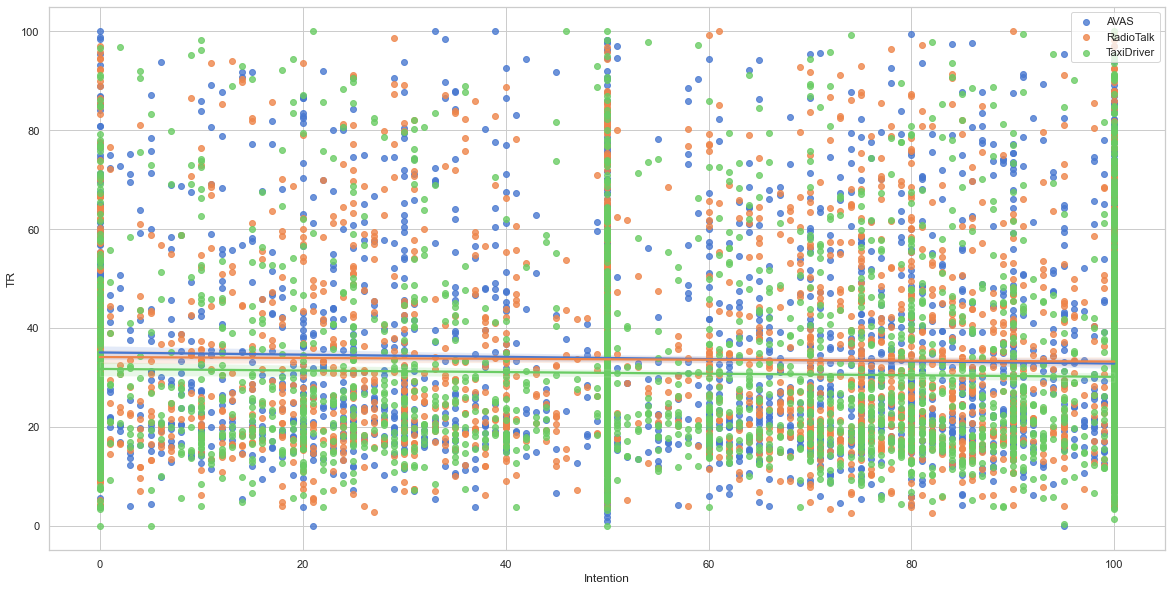

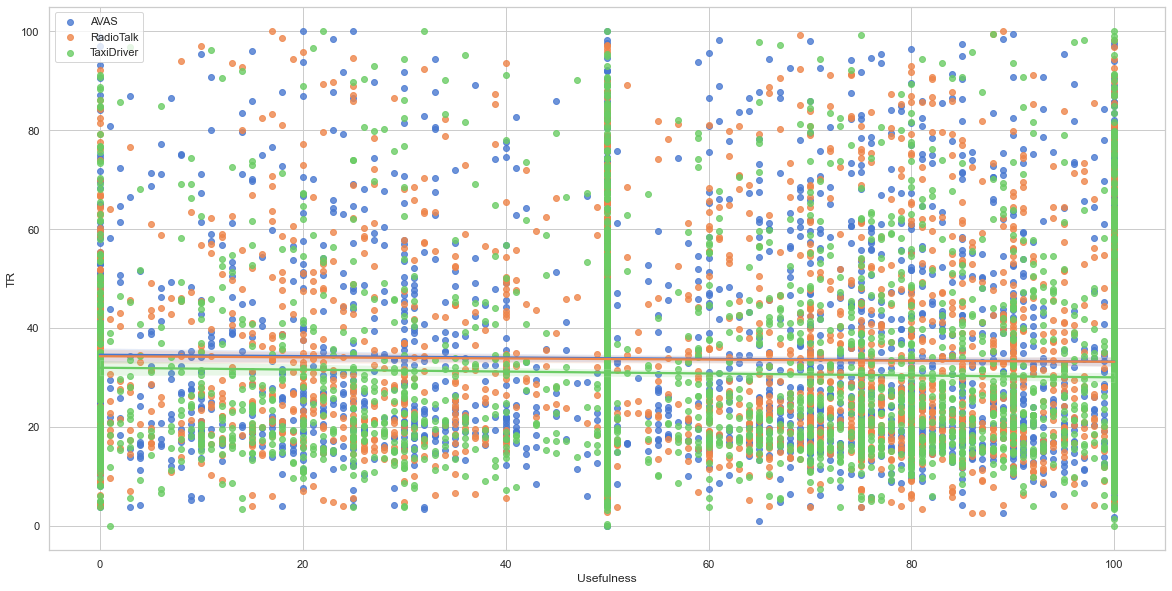

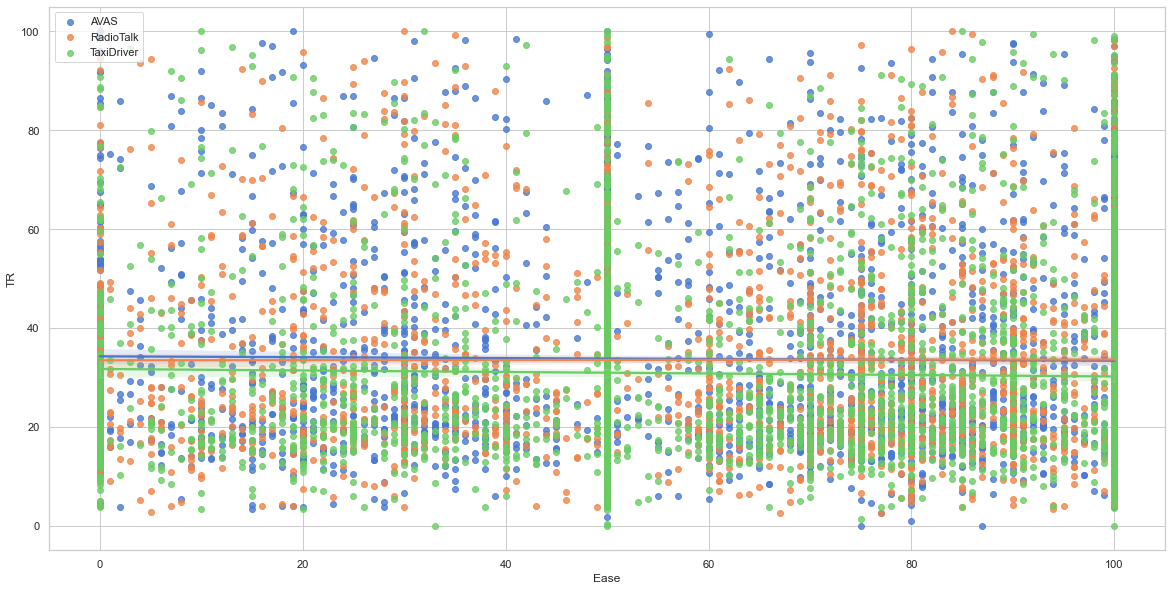

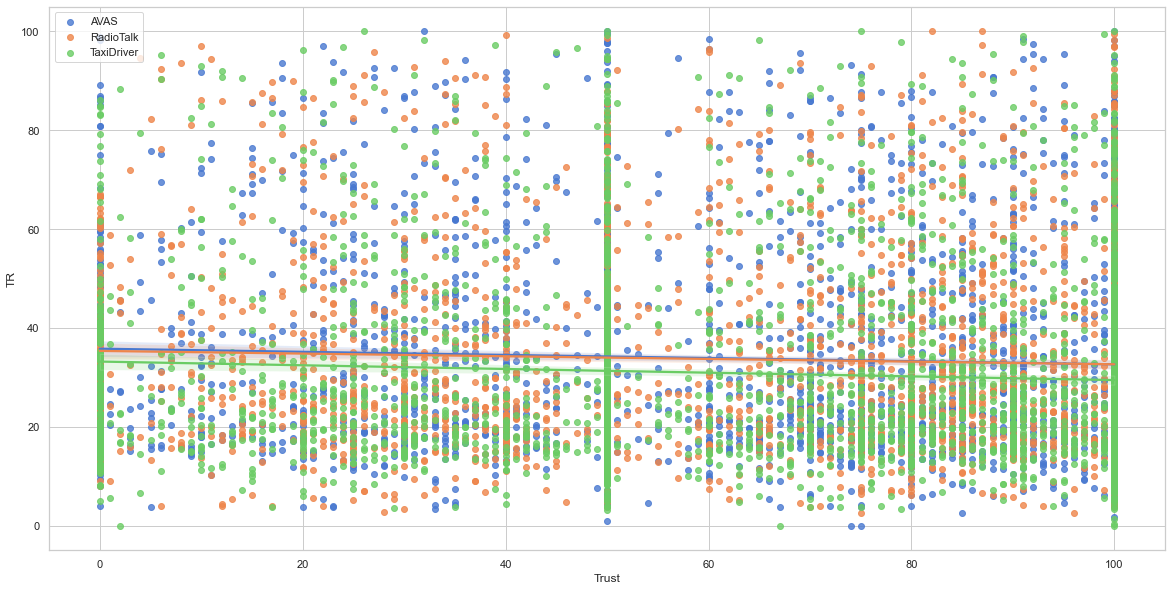

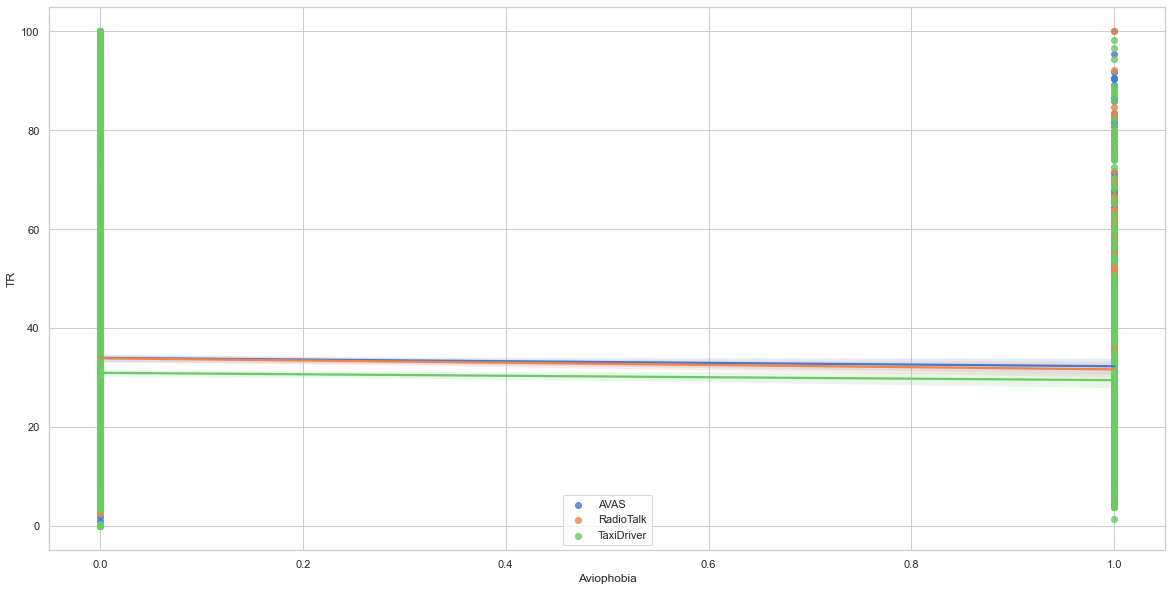

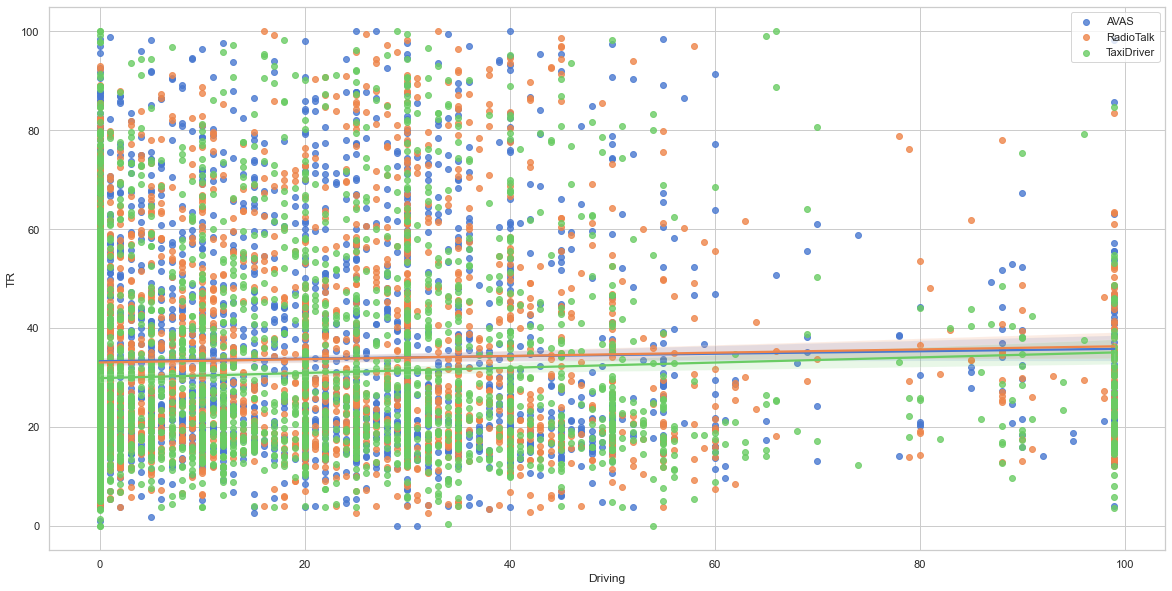

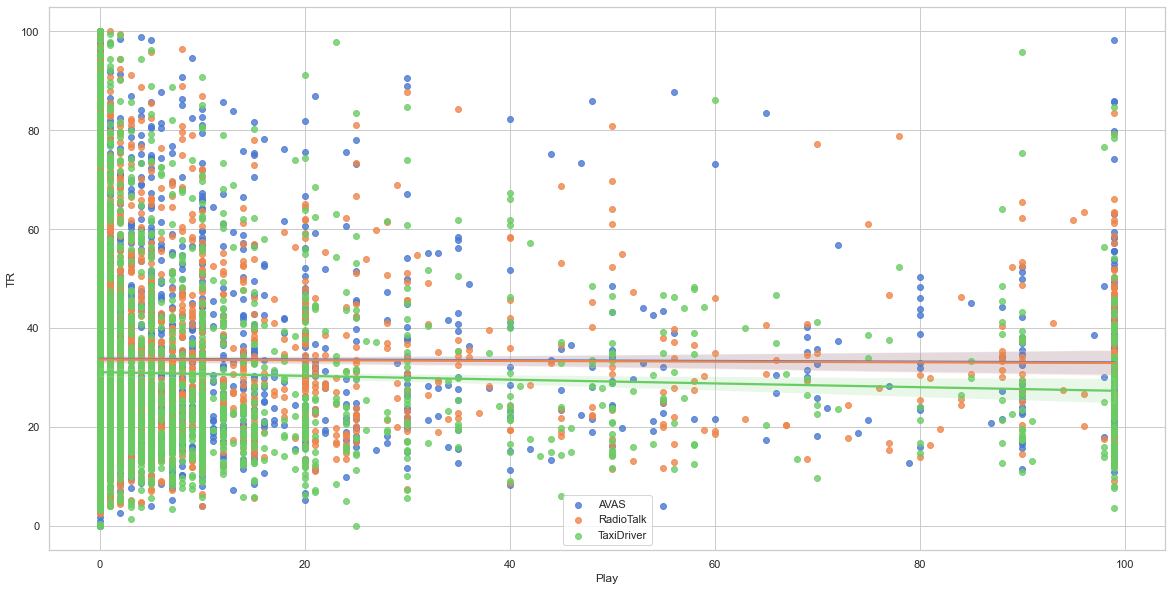

In [33]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="TR",
            x=col,
            color=next(palette),
            label=cnd,
        )
    plt.legend()
    plt.show()

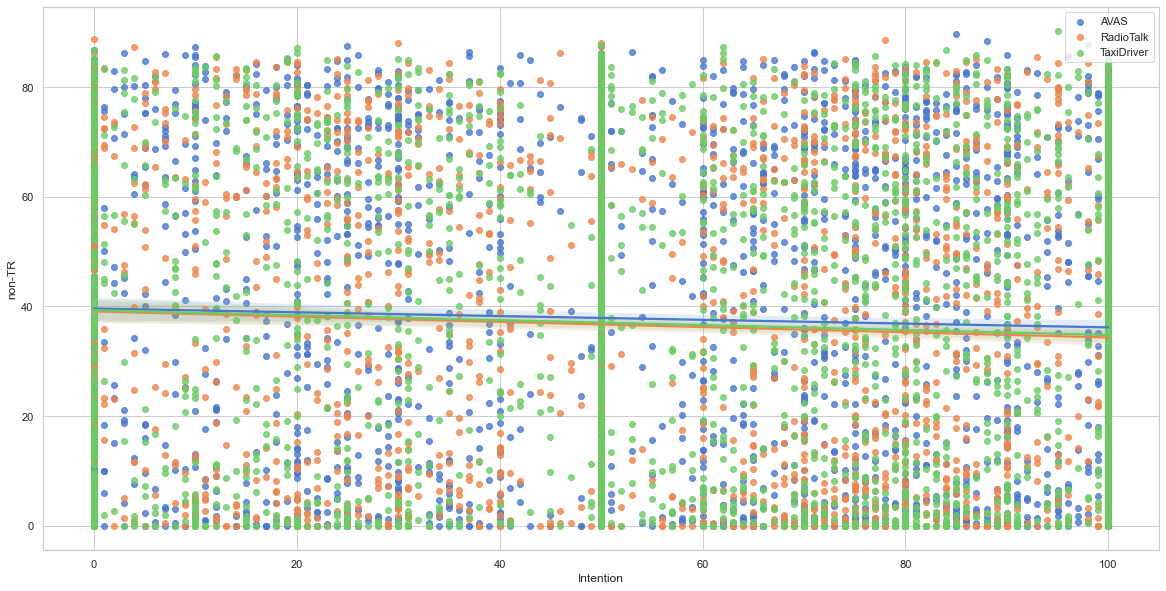

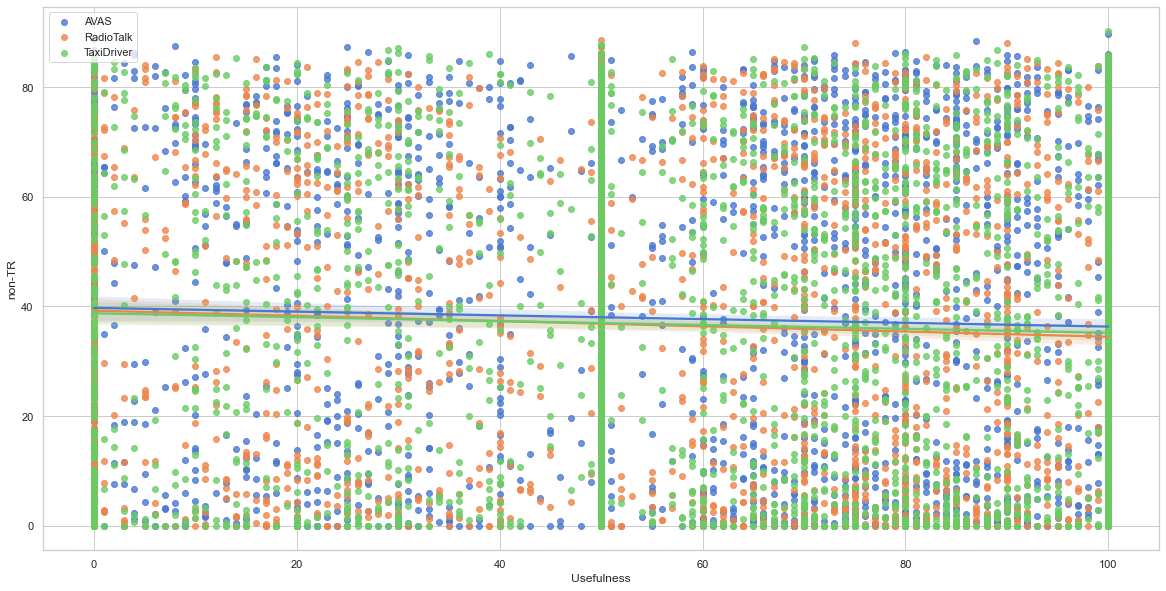

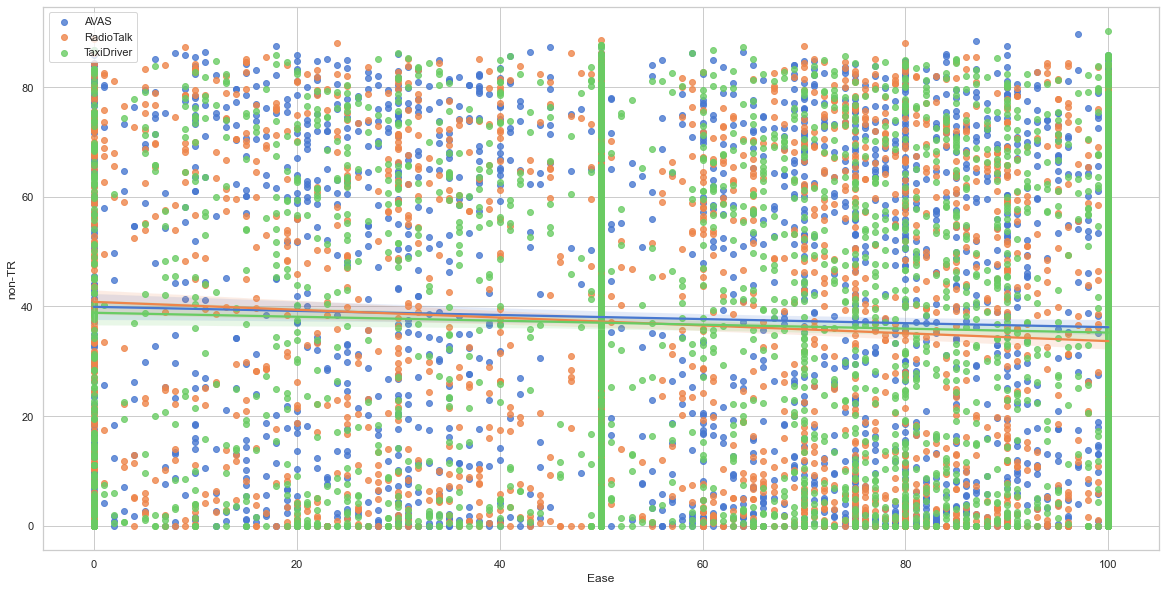

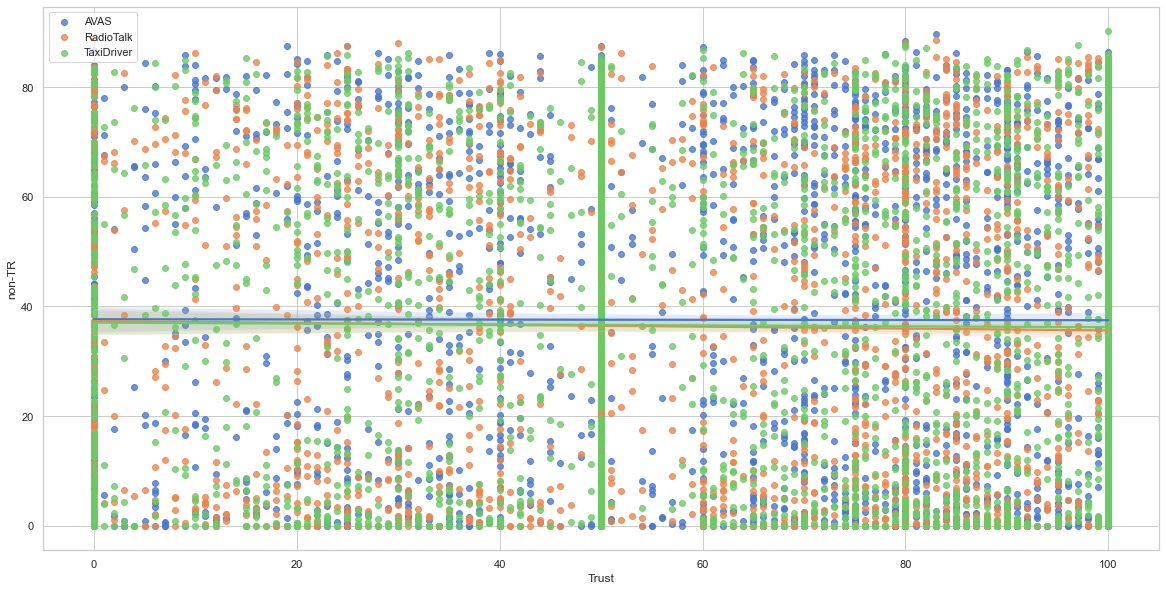

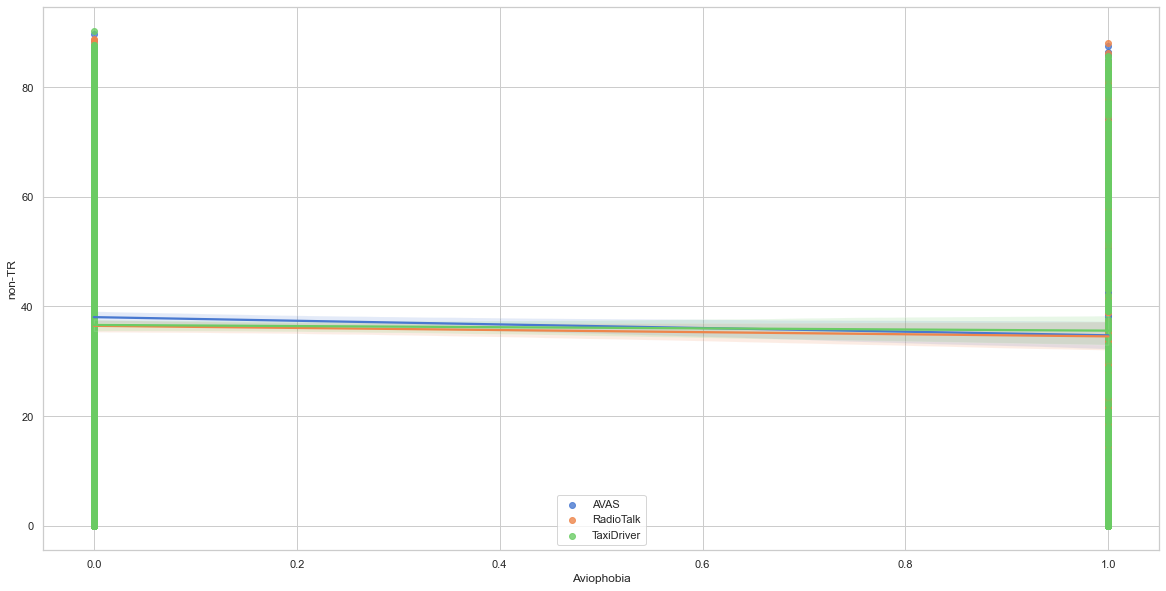

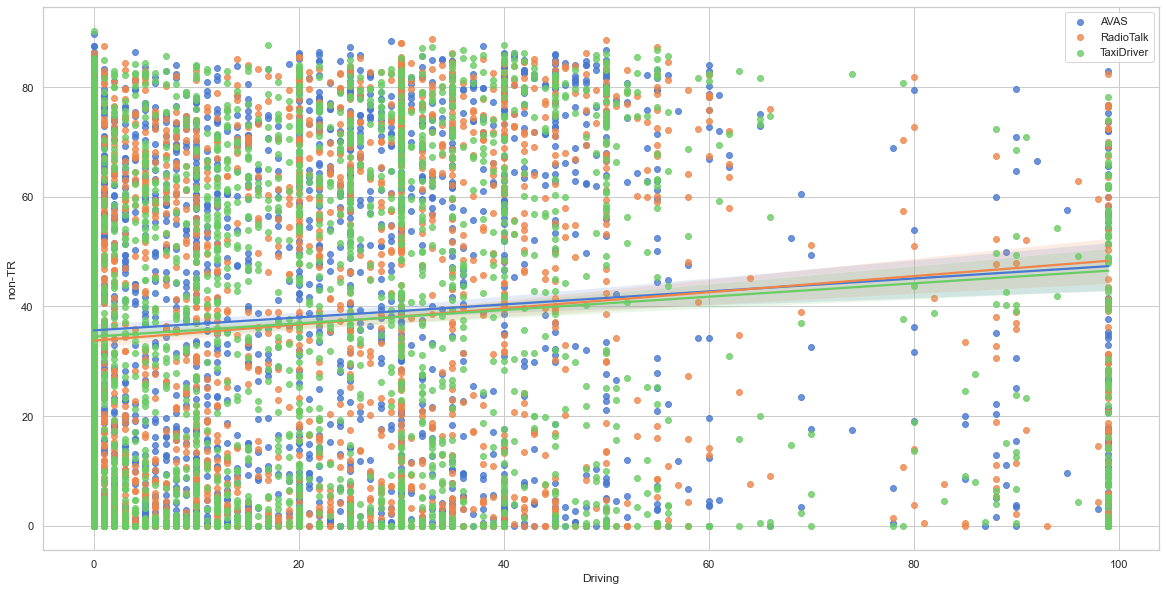

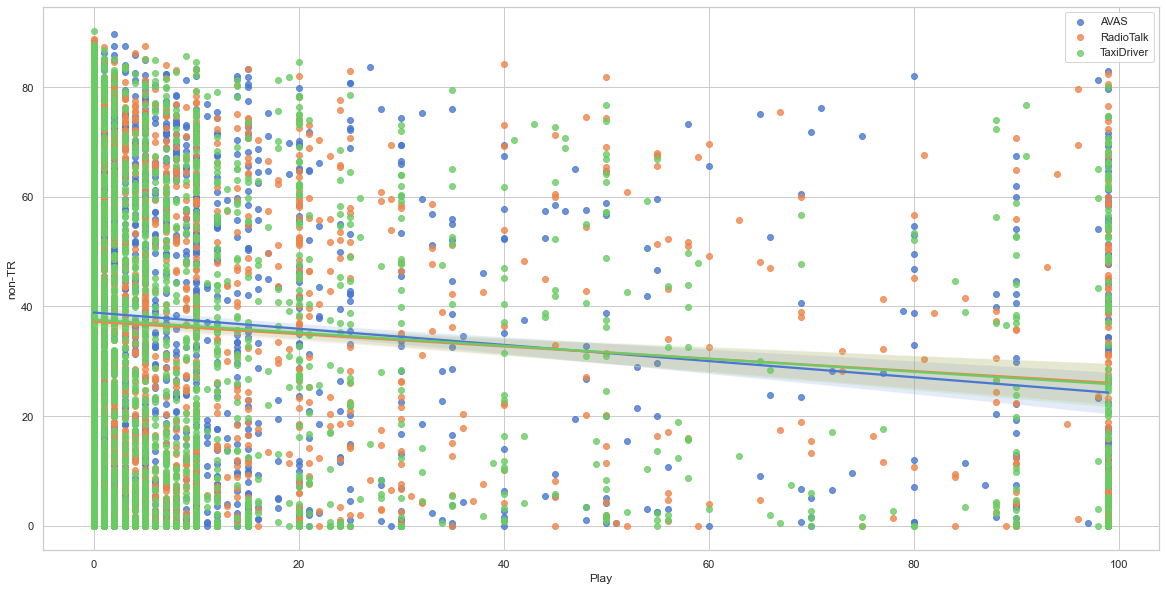

In [34]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        sns.regplot(
            data=gaze_ltr[gaze_ltr.condition == cnd],
            y="non-TR",
            x=col,
            color=next(palette),
            label=cnd,
        )
    plt.legend()
    plt.show()

In [35]:
select = parts[parts.questionnaire == "Yes"]
gaze_ctr = gaze_ctr.join(
    select[["expo", "side", "questionnaire"]], how="outer"
)
# select = gaze_ctr[gaze_ctr.questionnaire == "Yes"]
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Gender",
    "Age",
    "Aviophobia",
    "Driving",
    "Play",
    "VR",
]
gaze_ctr = gaze_ctr.join(quests[cols], how="outer")
gaze_ctr

TR  non-TR   condition  expo   side  \
0002d624d34c44369f109d1c5d076d1b 32.927  28.049  TaxiDriver   NaN    NaN   
00040aa093c944f98a5c2f9ef515782a 14.815   0.000        AVAS   NaN    NaN   
000506554eb6453f94b51947d824731c 19.118  70.588        AVAS   NaN    NaN   
0007826f6d5a4bc8a4bf504f0f53a69f 30.769   0.000  TaxiDriver   NaN    NaN   
000966a73bce402d8d92ece7eb13e1f7 34.884  29.070        AVAS  BMBF  right   
...                                 ...     ...         ...   ...    ...   
fff21f23099e4e70b09ebc727e6365e5 32.609   0.000        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12 69.811   0.000  TaxiDriver   MSW  right   
fff8201205c049afb0c43c49f916ed54 12.727  45.455  TaxiDriver   NaN    NaN   
fffb6dd07f9c469aaf2fdb1272f154ec 29.630  40.741        AVAS   MSW  right   
fffe9dc8929a41588b7948267fcddbc9 28.916  53.012   RadioTalk   NaN    NaN   

                                 questionnaire  Intention  Usefulness    Ease  \
0002d624d34c44369f109d1c5d076d1b           NaN        NaN         NaN     NaN   
00040aa093c944f98a5c2f9ef515782a           NaN        NaN         NaN     NaN   
000506554eb6453f94b51947d824731c           NaN        NaN         NaN     NaN   
0007826f6d5a4bc8a4bf504f0f53a69f           NaN        NaN         NaN     NaN   
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
...                                        ...        ...         ...     ...   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fff8201205c049afb0c43c49f916ed54           NaN        NaN         NaN     NaN   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   
fffe9dc8929a41588b7948267fcddbc9           NaN        NaN         NaN     NaN   

                                  Trust  Gender    Age  Aviophobia  Driving  \
0002d624d34c44369f109d1c5d076d1b    NaN     NaN    NaN         NaN      NaN   
00040aa093c944f98a5c2f9ef515782a    NaN     NaN    NaN         NaN      NaN   
000506554eb6453f94b51947d824731c    NaN     NaN    NaN         NaN      NaN   
0007826f6d5a4bc8a4bf504f0f53a69f    NaN     NaN    NaN         NaN      NaN   
000966a73bce402d8d92ece7eb13e1f7 68.000  Female 15.000       0.000    0.000   
...                                 ...     ...    ...         ...      ...   
fff21f23099e4e70b09ebc727e6365e5 89.000    Male 19.000       0.000    0.000   
fff77d4abc9b4937a78f5e4a8b9def12 50.000    Male 46.000       0.000   27.000   
fff8201205c049afb0c43c49f916ed54    NaN     NaN    NaN         NaN      NaN   
fffb6dd07f9c469aaf2fdb1272f154ec 36.000    Male 14.000       0.000    0.000   
fffe9dc8929a41588b7948267fcddbc9    NaN     NaN    NaN         NaN      NaN   

                                   Play                  VR  
0002d624d34c44369f109d1c5d076d1b    NaN                 NaN  
00040aa093c944f98a5c2f9ef515782a    NaN                 NaN  
000506554eb6453f94b51947d824731c    NaN                 NaN  
0007826f6d5a4bc8a4bf504f0f53a69f    NaN                 NaN  
000966a73bce402d8d92ece7eb13e1f7  4.000                once  
...                                 ...                 ...  
fff21f23099e4e70b09ebc727e6365e5 30.000                once  
fff77d4abc9b4937a78f5e4a8b9def12  0.000  less than 10 times  
fff8201205c049afb0c43c49f916ed54    NaN                 NaN  
fffb6dd07f9c469aaf2fdb1272f154ec 15.000  less than 10 times  
fffe9dc8929a41588b7948267fcddbc9    NaN                 NaN  

[24356 rows x 16 columns]

In [36]:
gaze_ctr = gaze_ctr[gaze_ctr.questionnaire == "Yes"]
gaze_ctr

TR  non-TR   condition  expo   side  \
000966a73bce402d8d92ece7eb13e1f7 34.884  29.070        AVAS  BMBF  right   
000ea0a15c0d476f89d084116e7b1e86 28.169   4.225        AVAS   MSW  right   
0015a3c9144248fb9571311e1140d7d0 44.615  40.000        AVAS   MSW  right   
0018e0af4c064093bab6f1d1d627b37f 14.706  47.059  TaxiDriver   MSW   left   
001f482723604d929eff67b8e59f1db1 19.403  43.284   RadioTalk   MSW   left   
...                                 ...     ...         ...   ...    ...   
ffe8b0db1e4640d695641d7b6bd2099d 12.308  81.538  TaxiDriver   MSW  right   
ffeaa9becd4f451389d253b8ac0ba1bc  8.000  78.667        AVAS   MSW   left   
fff21f23099e4e70b09ebc727e6365e5 32.609   0.000        AVAS   MSW   left   
fff77d4abc9b4937a78f5e4a8b9def12 69.811   0.000  TaxiDriver   MSW  right   
fffb6dd07f9c469aaf2fdb1272f154ec 29.630  40.741        AVAS   MSW  right   

                                 questionnaire  Intention  Usefulness    Ease  \
000966a73bce402d8d92ece7eb13e1f7           Yes     50.000      50.000  50.000   
000ea0a15c0d476f89d084116e7b1e86           Yes     88.000      56.000  25.000   
0015a3c9144248fb9571311e1140d7d0           Yes     71.000      50.000  83.000   
0018e0af4c064093bab6f1d1d627b37f           Yes    100.000      89.000  82.000   
001f482723604d929eff67b8e59f1db1           Yes     37.000      39.000  45.000   
...                                        ...        ...         ...     ...   
ffe8b0db1e4640d695641d7b6bd2099d           Yes    100.000     100.000 100.000   
ffeaa9becd4f451389d253b8ac0ba1bc           Yes     83.000       0.000  87.000   
fff21f23099e4e70b09ebc727e6365e5           Yes     50.000      50.000  56.000   
fff77d4abc9b4937a78f5e4a8b9def12           Yes     50.000      30.000 100.000   
fffb6dd07f9c469aaf2fdb1272f154ec           Yes     50.000      20.000  33.000   

                                   Trust  Gender    Age  Aviophobia  Driving  \
000966a73bce402d8d92ece7eb13e1f7  68.000  Female 15.000       0.000    0.000   
000ea0a15c0d476f89d084116e7b1e86 100.000    Male 12.000       0.000    0.000   
0015a3c9144248fb9571311e1140d7d0  50.000    Male 23.000       1.000    4.000   
0018e0af4c064093bab6f1d1d627b37f 100.000  Female 12.000       0.000    0.000   
001f482723604d929eff67b8e59f1db1 100.000     NaN 81.000       0.000    0.000   
...                                  ...     ...    ...         ...      ...   
ffe8b0db1e4640d695641d7b6bd2099d 100.000    Male 17.000       0.000    0.000   
ffeaa9becd4f451389d253b8ac0ba1bc  61.000  Female 12.000       0.000    0.000   
fff21f23099e4e70b09ebc727e6365e5  89.000    Male 19.000       0.000    0.000   
fff77d4abc9b4937a78f5e4a8b9def12  50.000    Male 46.000       0.000   27.000   
fffb6dd07f9c469aaf2fdb1272f154ec  36.000    Male 14.000       0.000    0.000   

                                   Play                  VR  
000966a73bce402d8d92ece7eb13e1f7  4.000                once  
000ea0a15c0d476f89d084116e7b1e86  9.000  less than 10 times  
0015a3c9144248fb9571311e1140d7d0  4.000  more than 10 times  
0018e0af4c064093bab6f1d1d627b37f  0.000  less than 10 times  
001f482723604d929eff67b8e59f1db1  5.000  less than 10 times  
...                                 ...                 ...  
ffe8b0db1e4640d695641d7b6bd2099d 50.000  more than 10 times  
ffeaa9becd4f451389d253b8ac0ba1bc  2.000  less than 10 times  
fff21f23099e4e70b09ebc727e6365e5 30.000                once  
fff77d4abc9b4937a78f5e4a8b9def12  0.000  less than 10 times  
fffb6dd07f9c469aaf2fdb1272f154ec 15.000  less than 10 times  

[9507 rows x 16 columns]

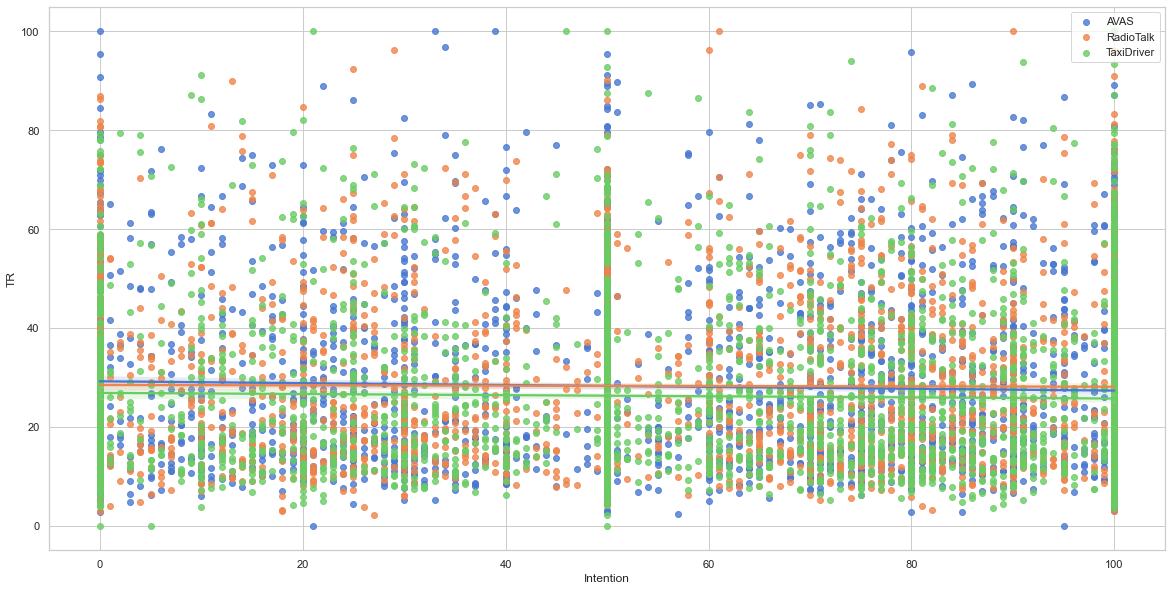

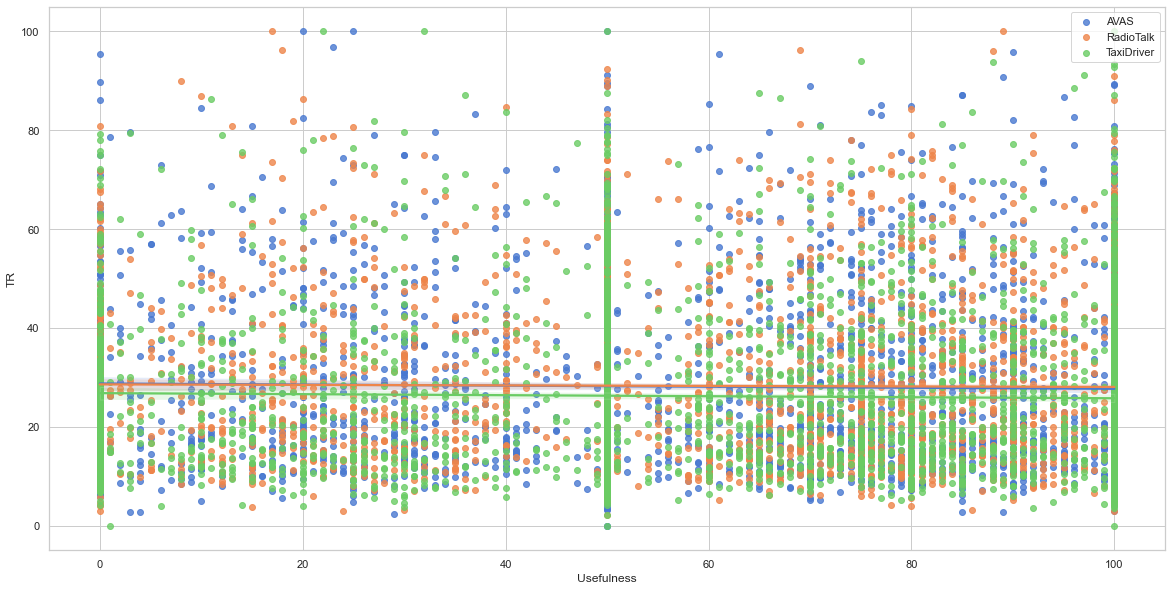

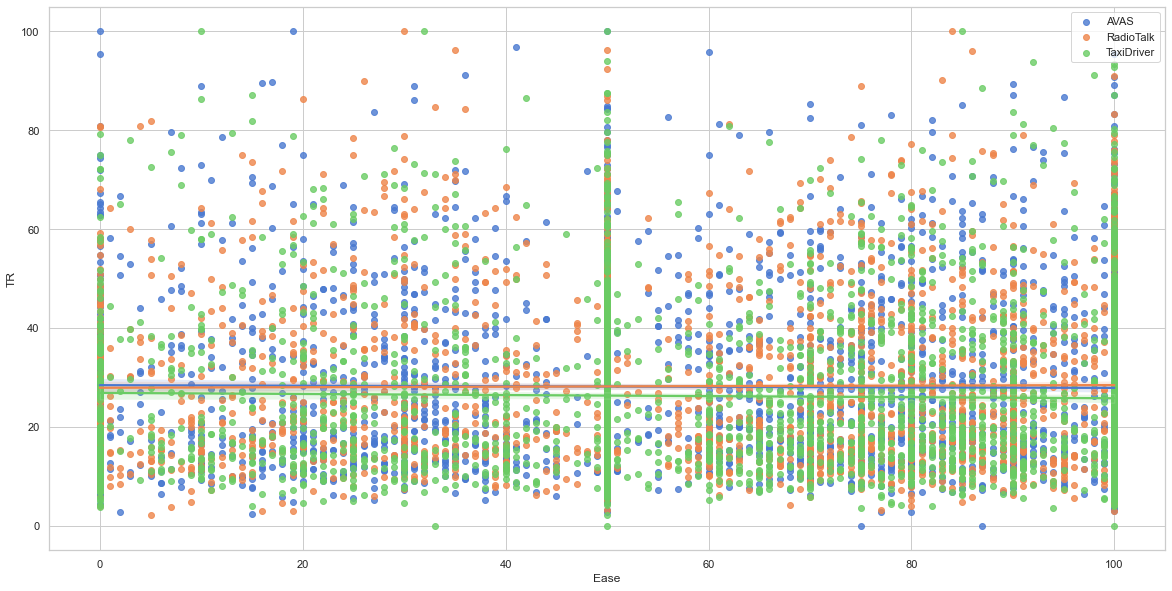

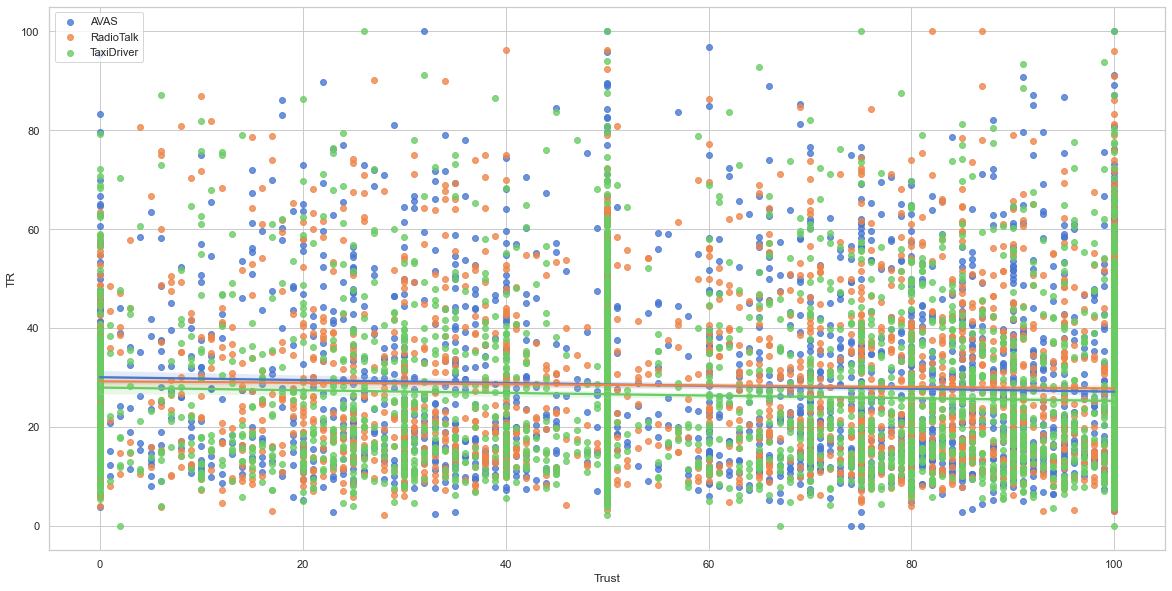

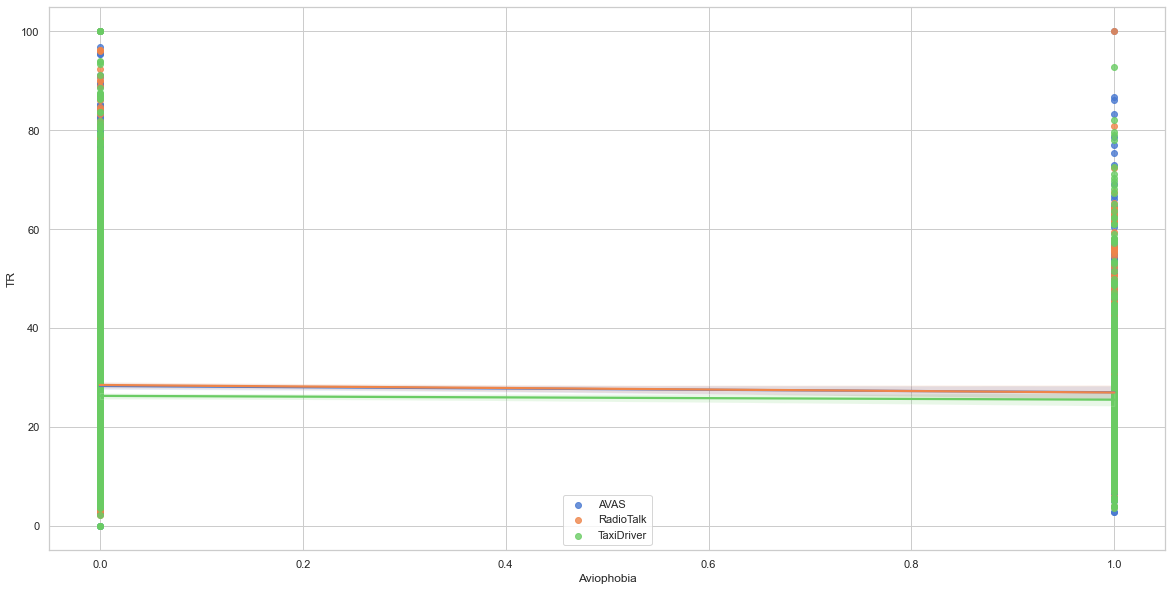

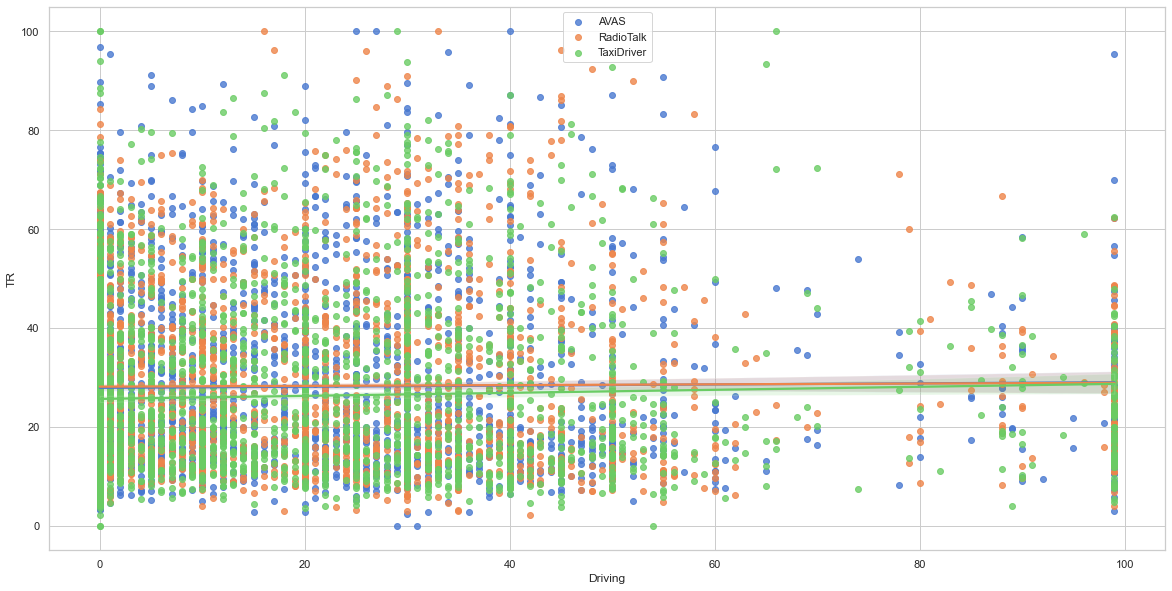

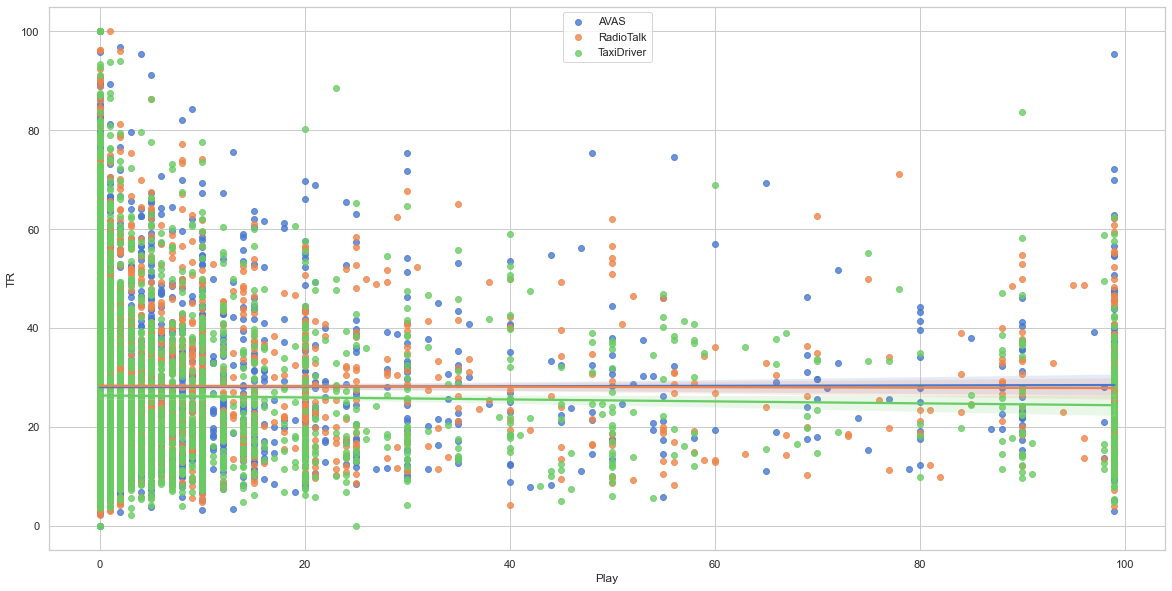

In [37]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        sns.regplot(
            data=gaze_ctr[gaze_ctr.condition == cnd],
            y="TR",
            x=col,
            color=next(palette),
            label=cnd,
        )
    plt.legend()
    plt.show()

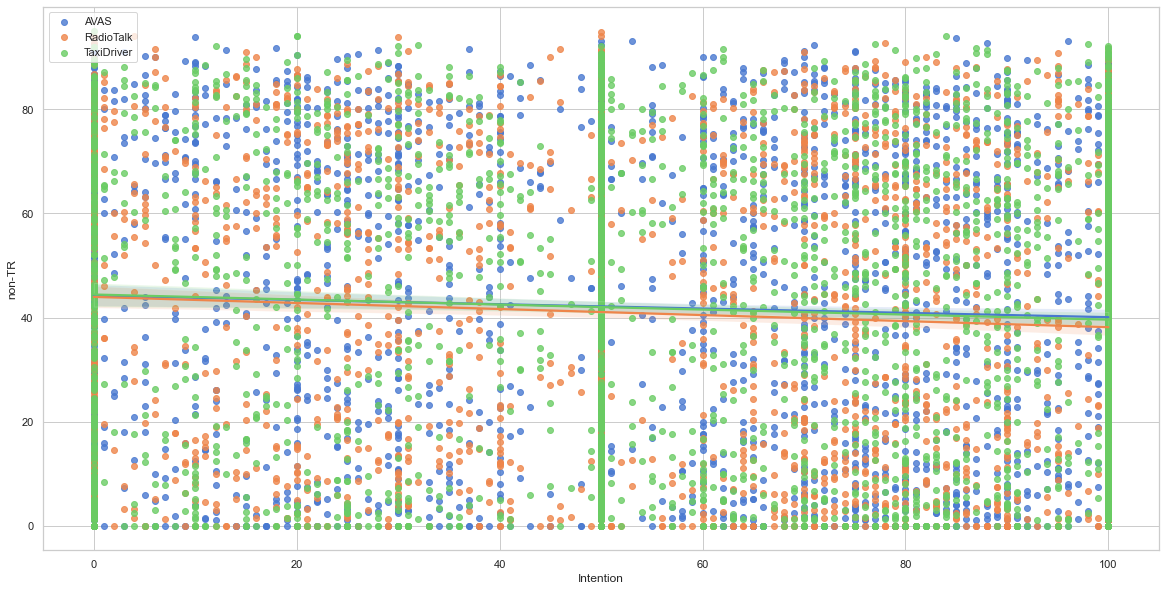

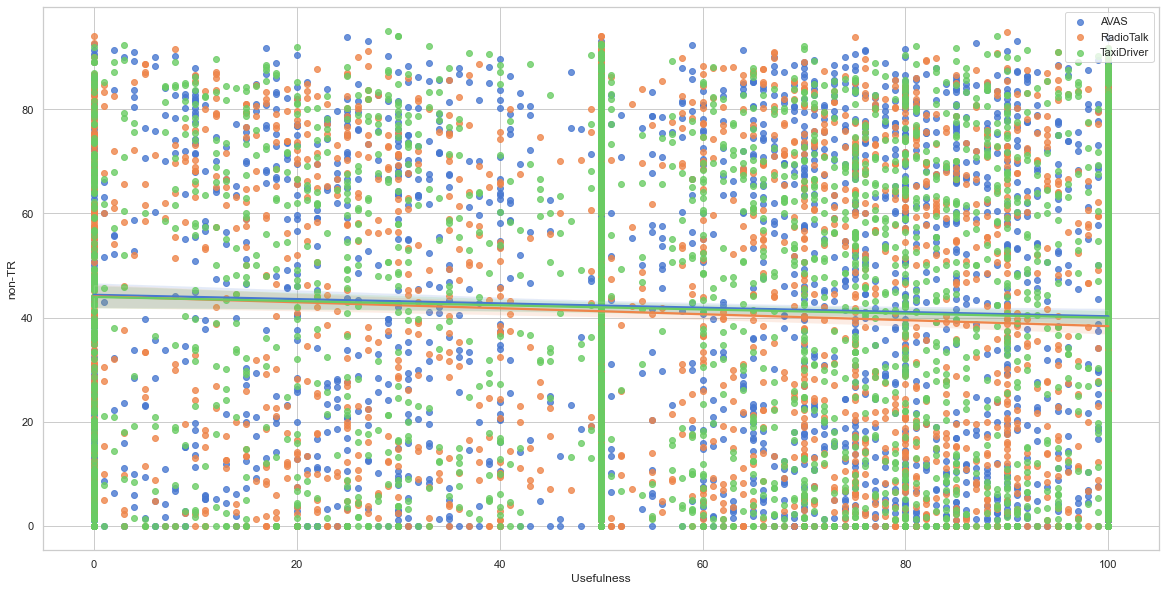

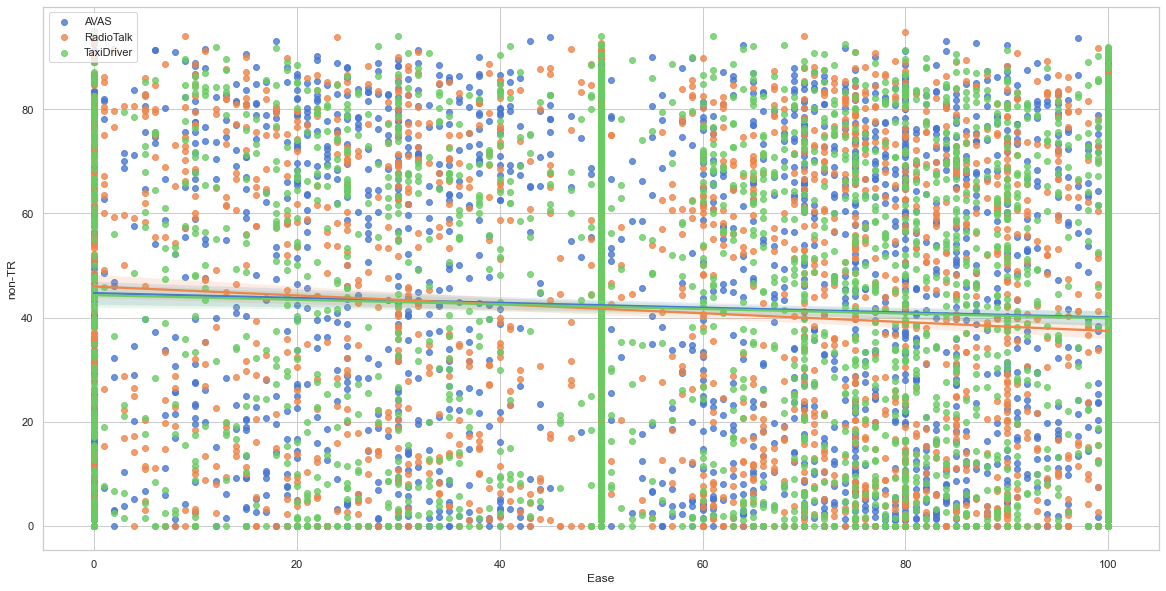

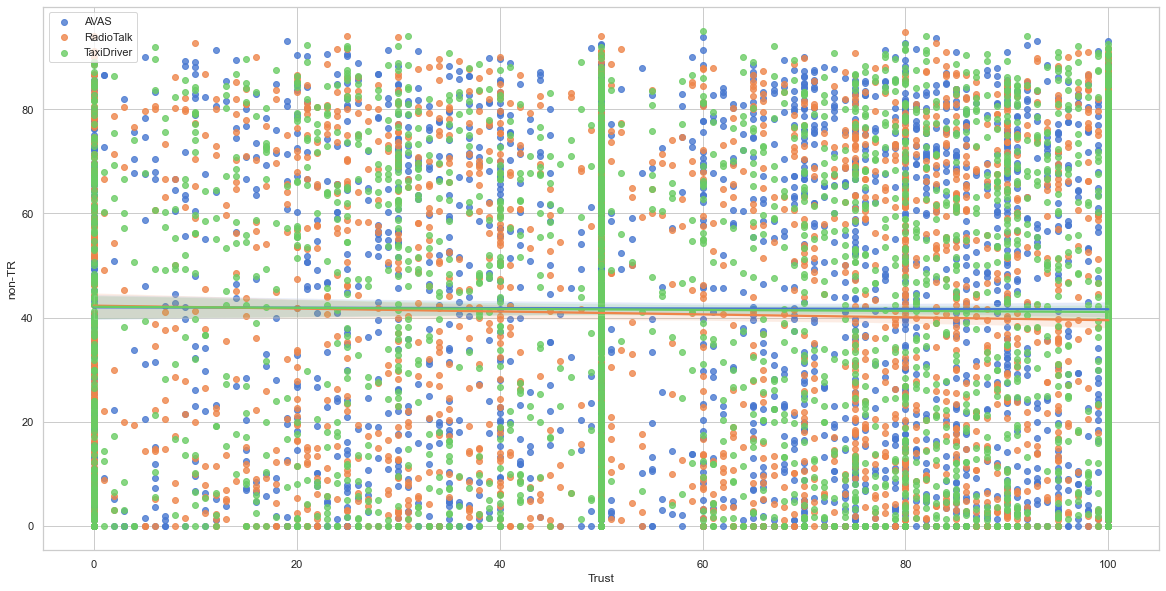

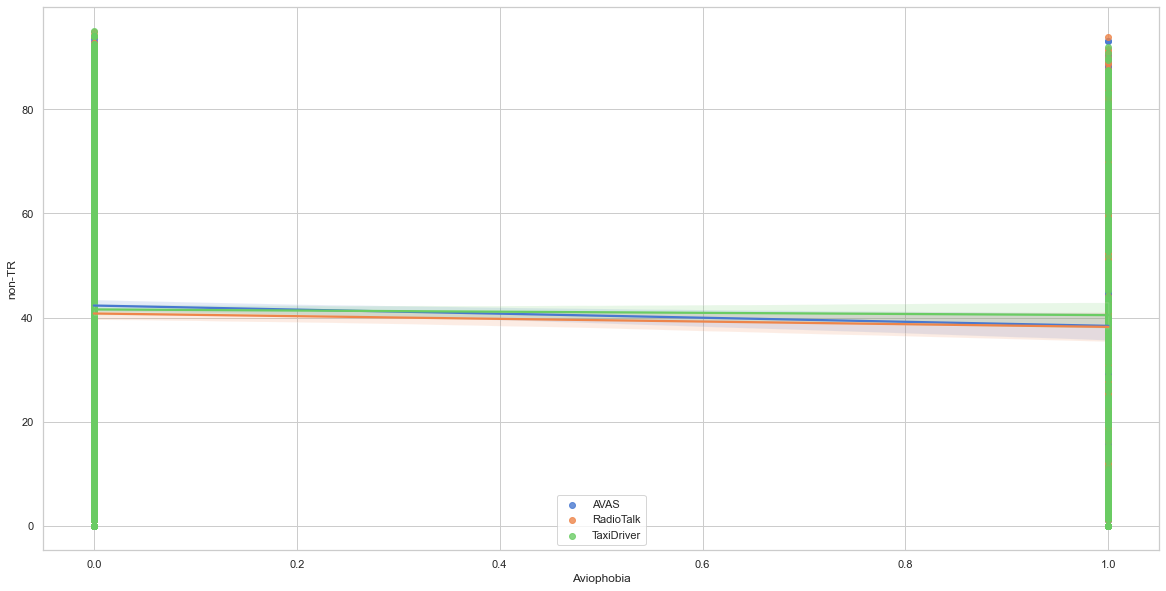

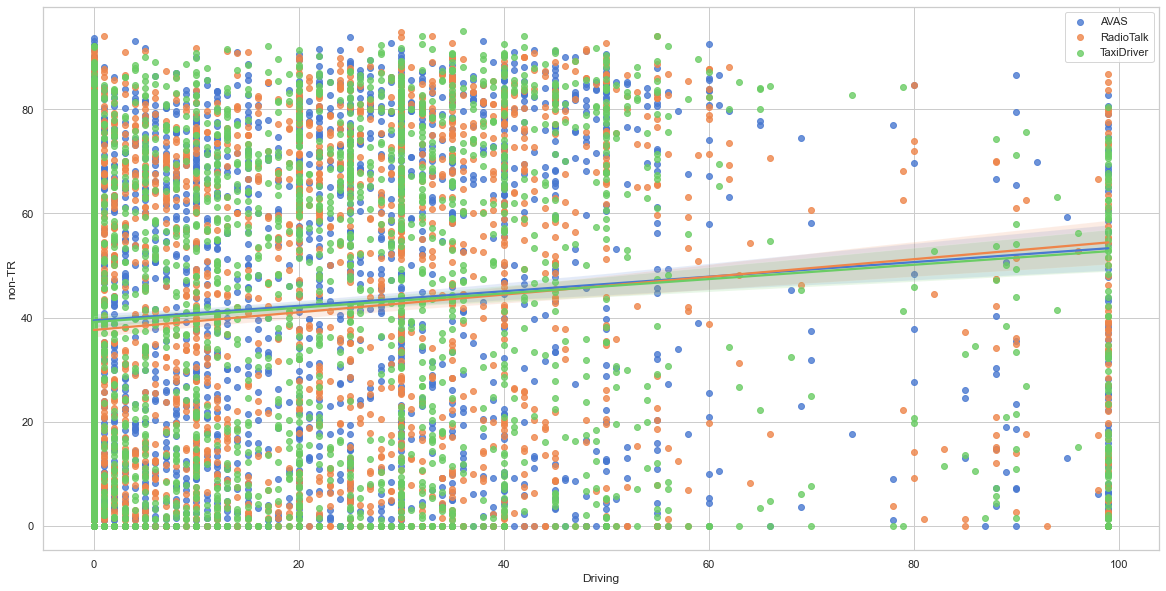

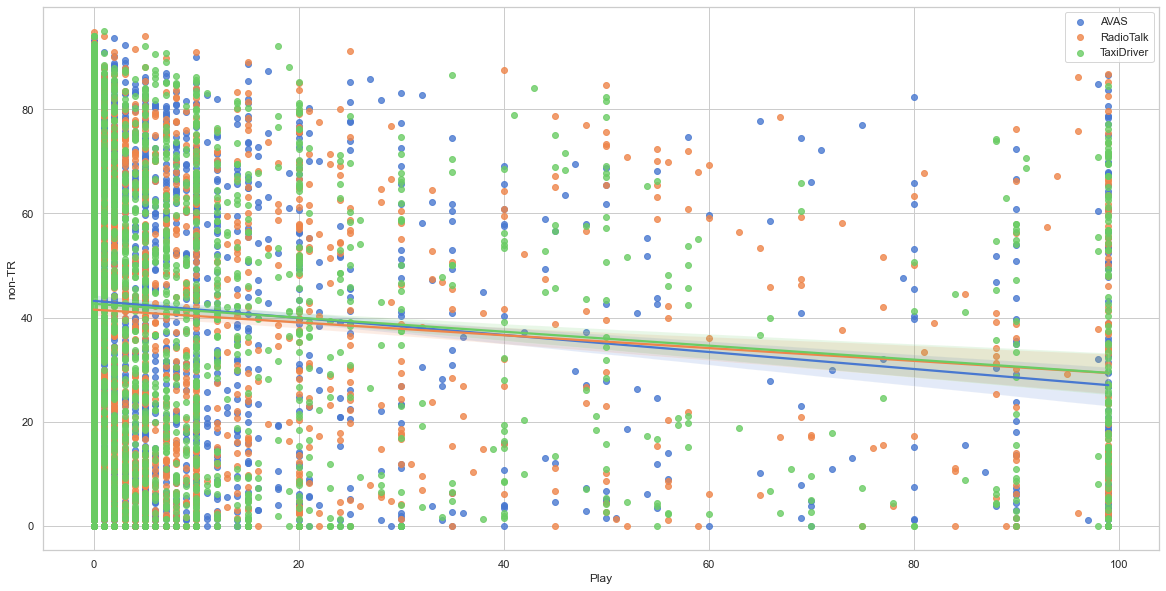

In [38]:
# palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
cols = [
    "Intention",
    "Usefulness",
    "Ease",
    "Trust",
    "Aviophobia",
    "Driving",
    "Play",
]
conds = ["AVAS", "RadioTalk", "TaxiDriver"]
for col in cols:
    palette = itertools.cycle(
        sns.color_palette(palette="muted")
    )  # color palette
    plt.figure(figsize=(20, 10))
    for cnd in conds:
        sns.regplot(
            data=gaze_ctr[gaze_ctr.condition == cnd],
            y="non-TR",
            x=col,
            color=next(palette),
            label=cnd,
        )
    plt.legend()
    plt.show()

In [39]:
gaze_ctr.Trust.dtype

dtype('float64')